In [2]:
#Important note: the run-time results obtained may not match the ones published in "Comparing the effectiveness of Logistic Regression versus Machine Learning algorithms in predicting consumer attrition" because of the difference in hardware configuration

#prework
#importing necessary libraries 

import warnings
warnings.simplefilter(action='ignore')

import datetime
from datetime import datetime

import numpy as np
import pandas as pd
pd.set_option('precision', 2)

# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

!pip install seaborn --upgrade
import seaborn as sns
sns.set_style('darkgrid')

# Statistics
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

print('Libraries ok')

Libraries ok


In [3]:
#Setting several paramaters and values 

font_size = 14
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 1
plt.rcParams['xtick.labelsize'] = font_size 
plt.rcParams['ytick.labelsize'] = font_size 
plt.rcParams['legend.fontsize'] = font_size 

colors = ['#6959CD', '#87CEEB']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'gray', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

print('Default values ok')

Default values ok


In [4]:
# Defining functions that will be re-used throughout  

def plot_continuous(feature):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_func = train_df.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df,
                     x=feature,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='steelblue',
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout();


print('plot continuos ok')

plot continuos ok


In [5]:
def plot_categorical(feature):
    '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(x=feature,
                  hue='Exited',
                  data=train_df,
                  palette=colors,
                  ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature,
                y='Exited',
                data=train_df,
                palette=colors_cat,
                ax=ax2)
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout();


print('plot categorical ok')

plot categorical ok


In [6]:
def plot_conf_mx(cm, ax):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned']);


print('confusion matrix plot ok')

confusion matrix plot ok


In [7]:
def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    '''Plot the learning curves for an estimator in the specified axes object.'''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14);


print('Lerning curve plot ok')

Lerning curve plot ok


In [8]:
def clf_performance(classifier, classifier_name, classifier_name_abv):
    '''Display the overall performance of a classifier with this template.'''
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=5,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout();


print('Performance plot ok')

Performance plot ok


In [9]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='none',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');


print('Bar plot features ok')

Bar plot features ok


In [10]:
def test_func(classifier, classifier_name, ax):
    '''Assess the performance on the test set and plot the confusion matrix.'''
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

    sns.heatmap(cm,
                annot=True,
                annot_kws={'fontsize': 24},
                cmap='Blues',
                ax=ax)

    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned']);


print('confusion matrix test set ok')

confusion matrix test set ok


In [11]:
#start of anlaysis
#importing dataset - full 10k segment 

df = pd.read_csv('C:/Users/luisb/iCloudDrive/Documents/Documents/MSPA-New/Capstone Project/Churn_Modeling.csv')

print('Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

Dataset Imported Successfully!

It contains 10000 rows and 14 columns.


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [12]:
#dropping useless columns
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [13]:
#looking into feature types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [14]:
#useufl stats
df.describe()

CreditScore       Age    Tenure    Balance  NumOfProducts  HasCrCard  \
count     10000.00  10000.00  10000.00   10000.00       10000.00   10000.00   
mean        650.53     38.92      5.01   76485.89           1.53       0.71   
std          96.65     10.49      2.89   62397.41           0.58       0.46   
min         350.00     18.00      0.00       0.00           1.00       0.00   
25%         584.00     32.00      3.00       0.00           1.00       0.00   
50%         652.00     37.00      5.00   97198.54           1.00       1.00   
75%         718.00     44.00      7.00  127644.24           2.00       1.00   
max         850.00     92.00     10.00  250898.09           4.00       1.00   

       IsActiveMember  EstimatedSalary   Exited  
count        10000.00         10000.00  10000.0  
mean             0.52        100090.24      0.2  
std              0.50         57510.49      0.4  
min              0.00            11.58      0.0  
25%              0.00         51002.11      0.0  
50%              1.00        100193.91      0.0  
75%              1.00        149388.25      0.0  
max              1.00        199992.48      1.0

In [15]:
#creating train/test set 

train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print('Train set: {} rows x {} columns'.format(train_df.shape[0],
                                               train_df.shape[1]))
print(' Test set: {} rows x {} columns'.format(test_df.shape[0],
                                               test_df.shape[1]))

Train set: 8000 rows x 11 columns
 Test set: 2000 rows x 11 columns


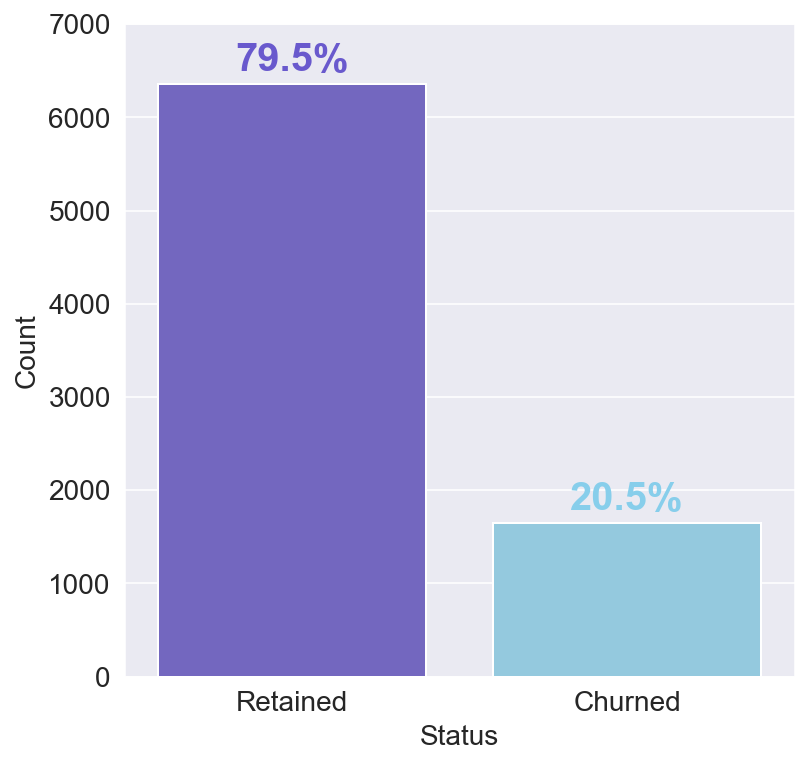

In [16]:
#EDA - target variable "exited"
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=train_df, palette=colors, ax=ax)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label = '{}%'.format(round((value / train_df['Exited'].shape[0]) * 100, 1))
    ax.annotate(label,
                xy=(index, value + 250),
                ha='center',
                va='center',
                color=colors[index],
                fontweight='bold',
                size=font_size + 6)

ax.set_xticklabels(['Retained', 'Churned'])
ax.set_xlabel('Status')
ax.set_ylabel('Count')
ax.set_ylim([0, 7000]);

In [17]:
#defining array for analysis between continuos and categoricla values

continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


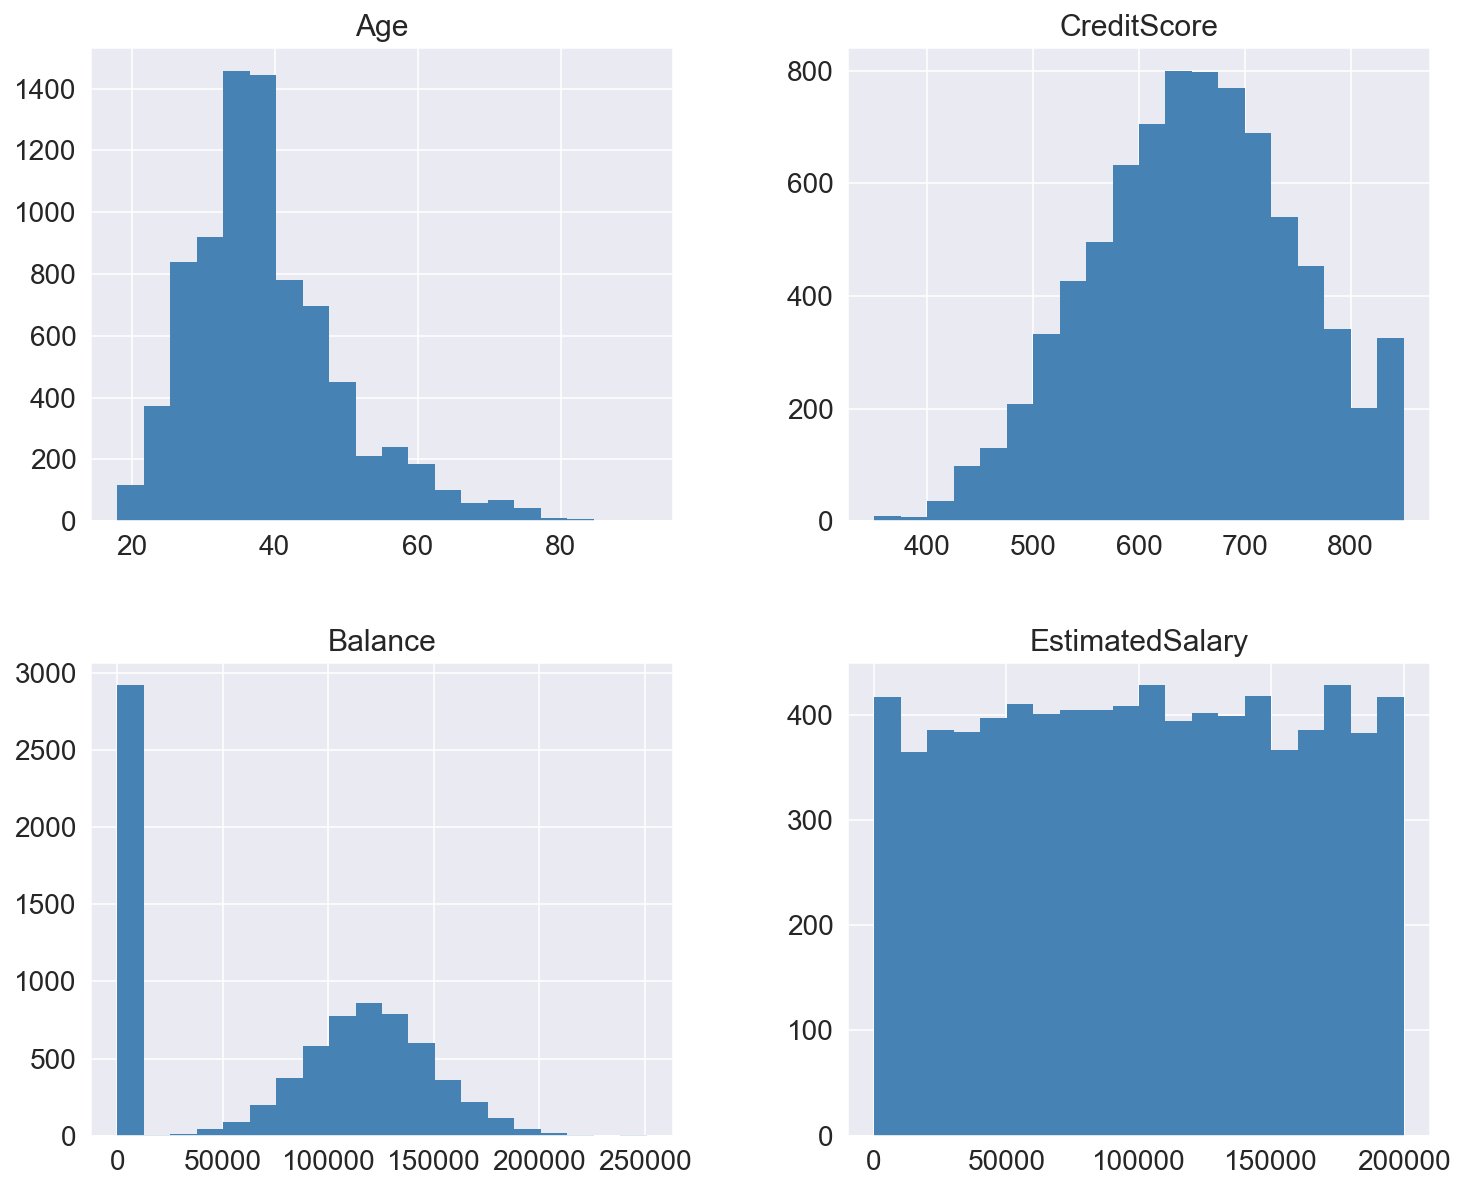

In [18]:
#Continuous variables
train_df[continuous].hist(figsize=(12, 10),
                          bins=20,
                          layout=(2, 2),
                          color='steelblue',
                          edgecolor='none',
                          linewidth=1.5);

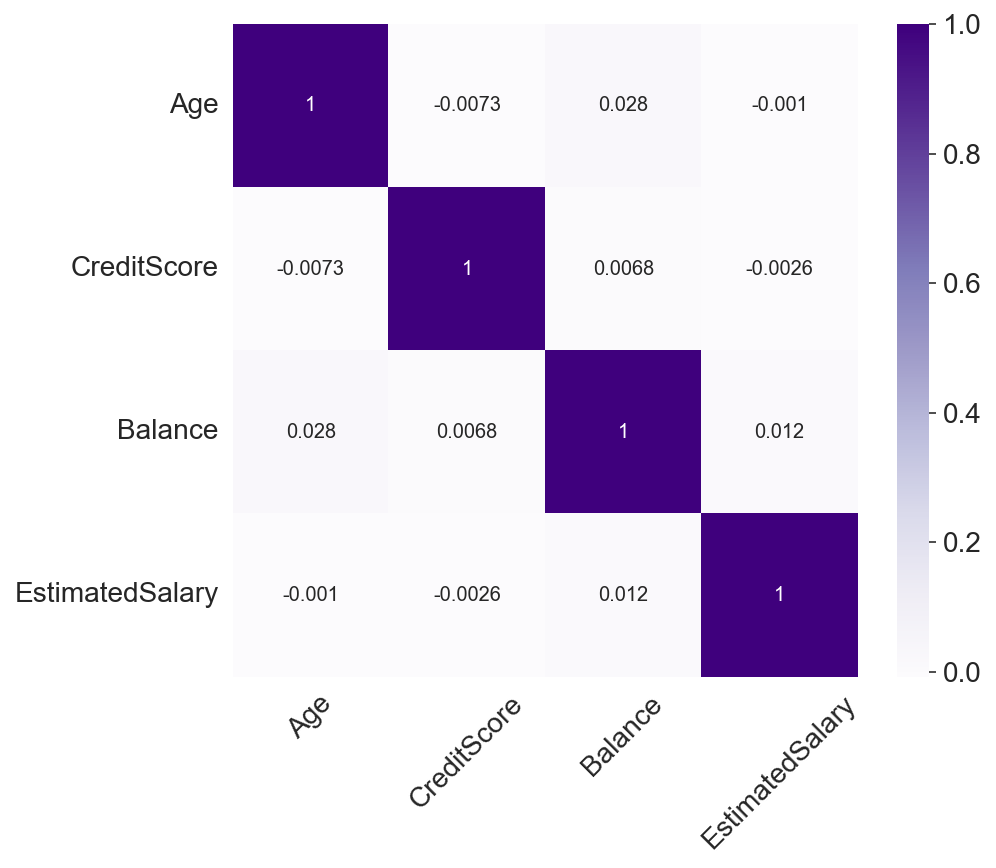

In [19]:
#Correlation between continuos variables 
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(train_df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 10},
            cmap='Purples',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

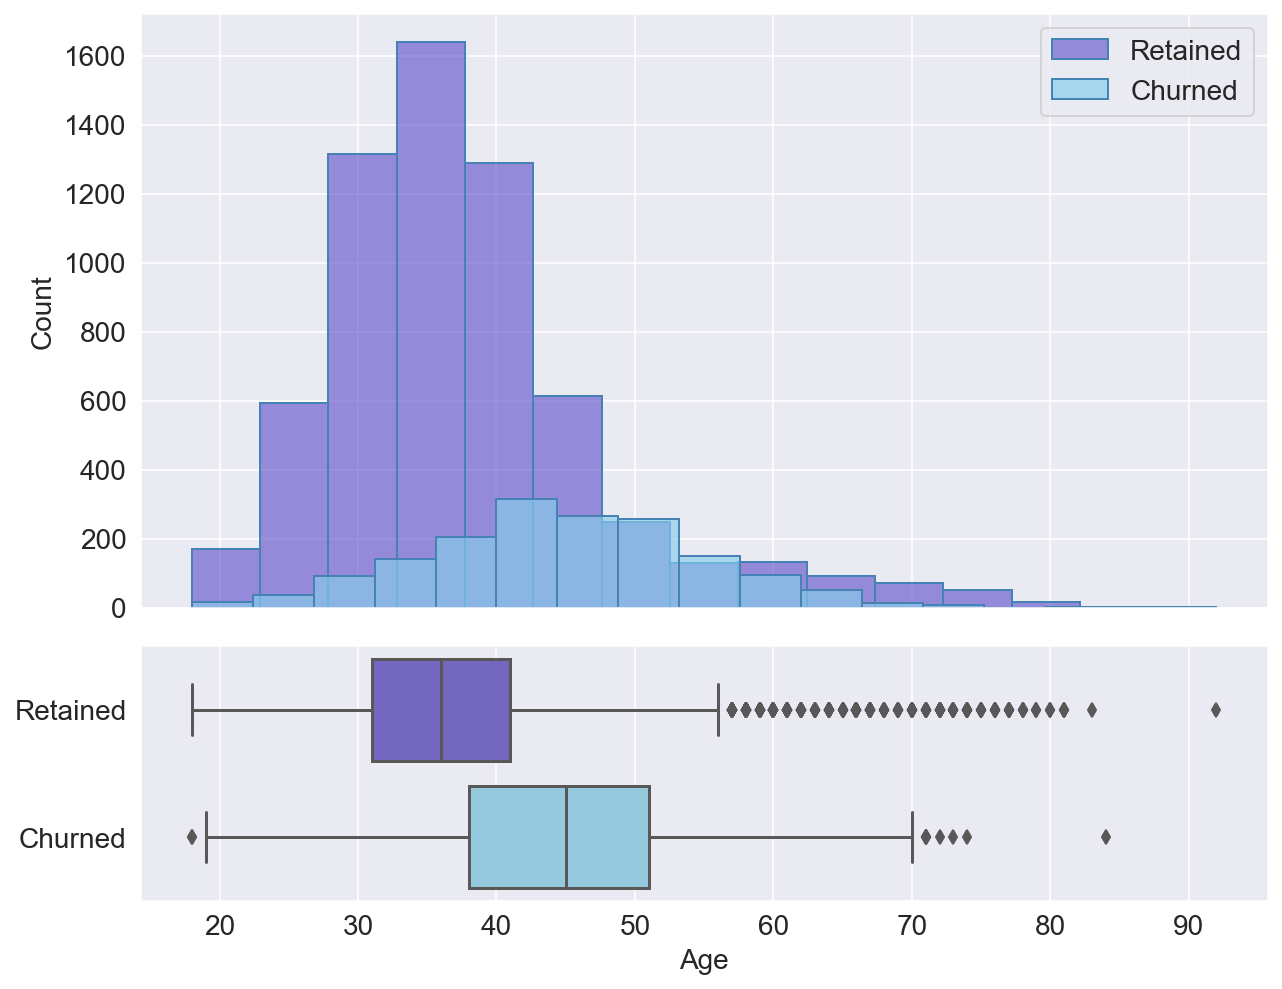

In [20]:
df_churned = train_df[train_df['Exited'] == 1]
df_retained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

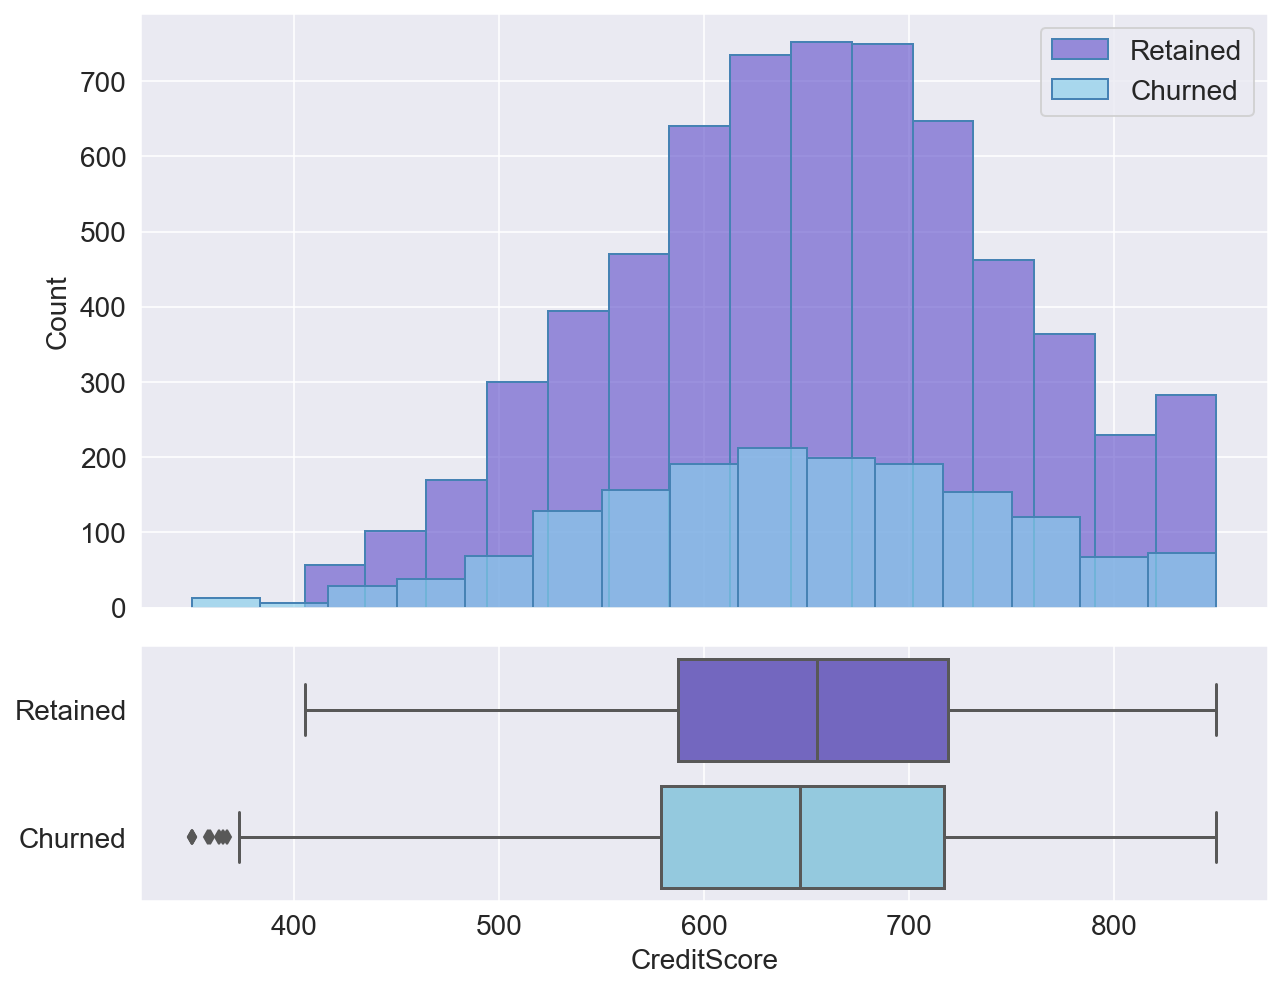

In [21]:
plot_continuous('CreditScore')

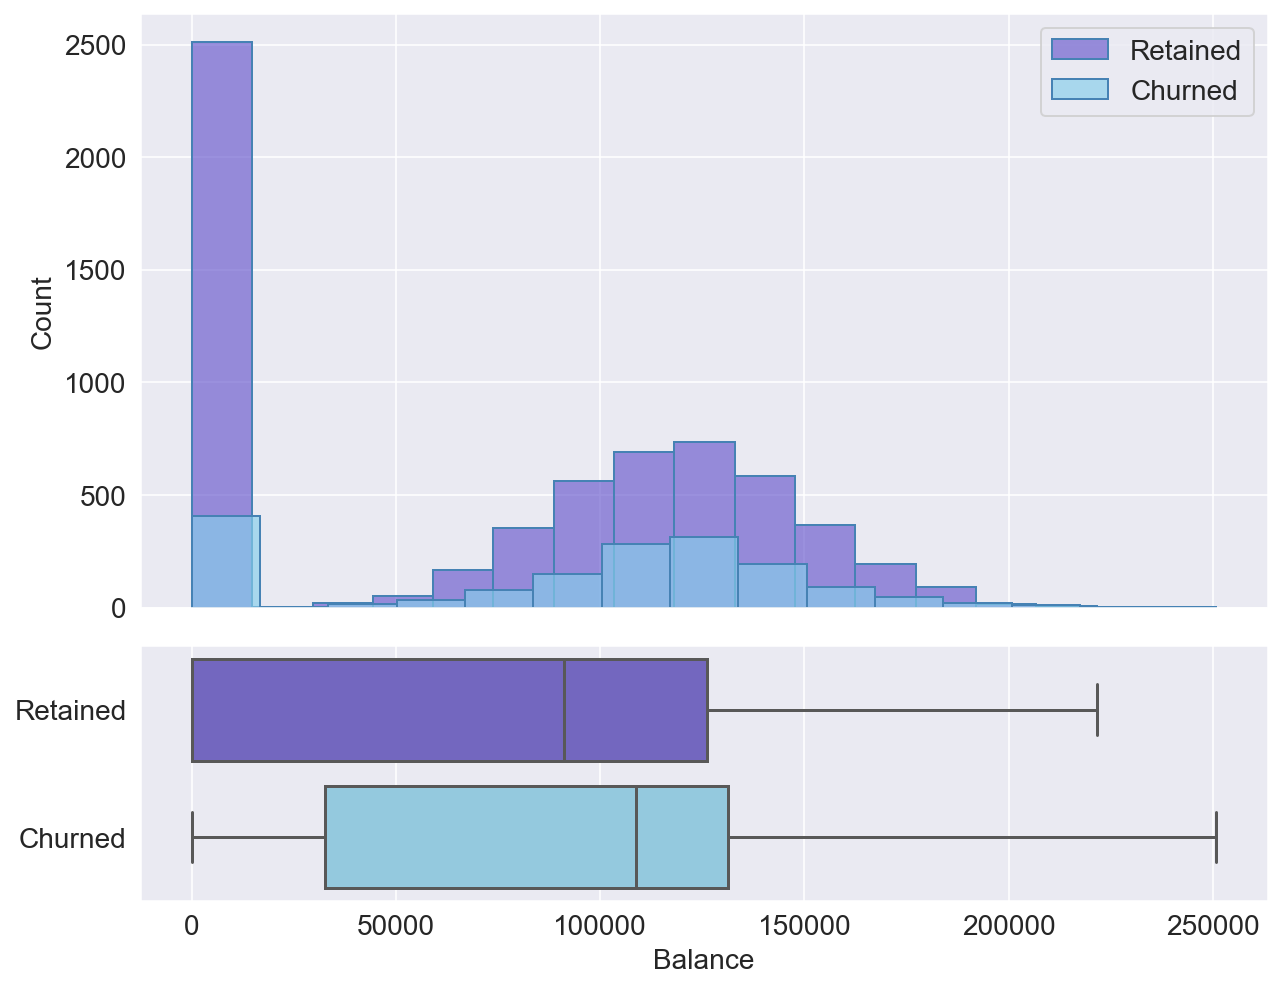

In [22]:
plot_continuous('Balance')

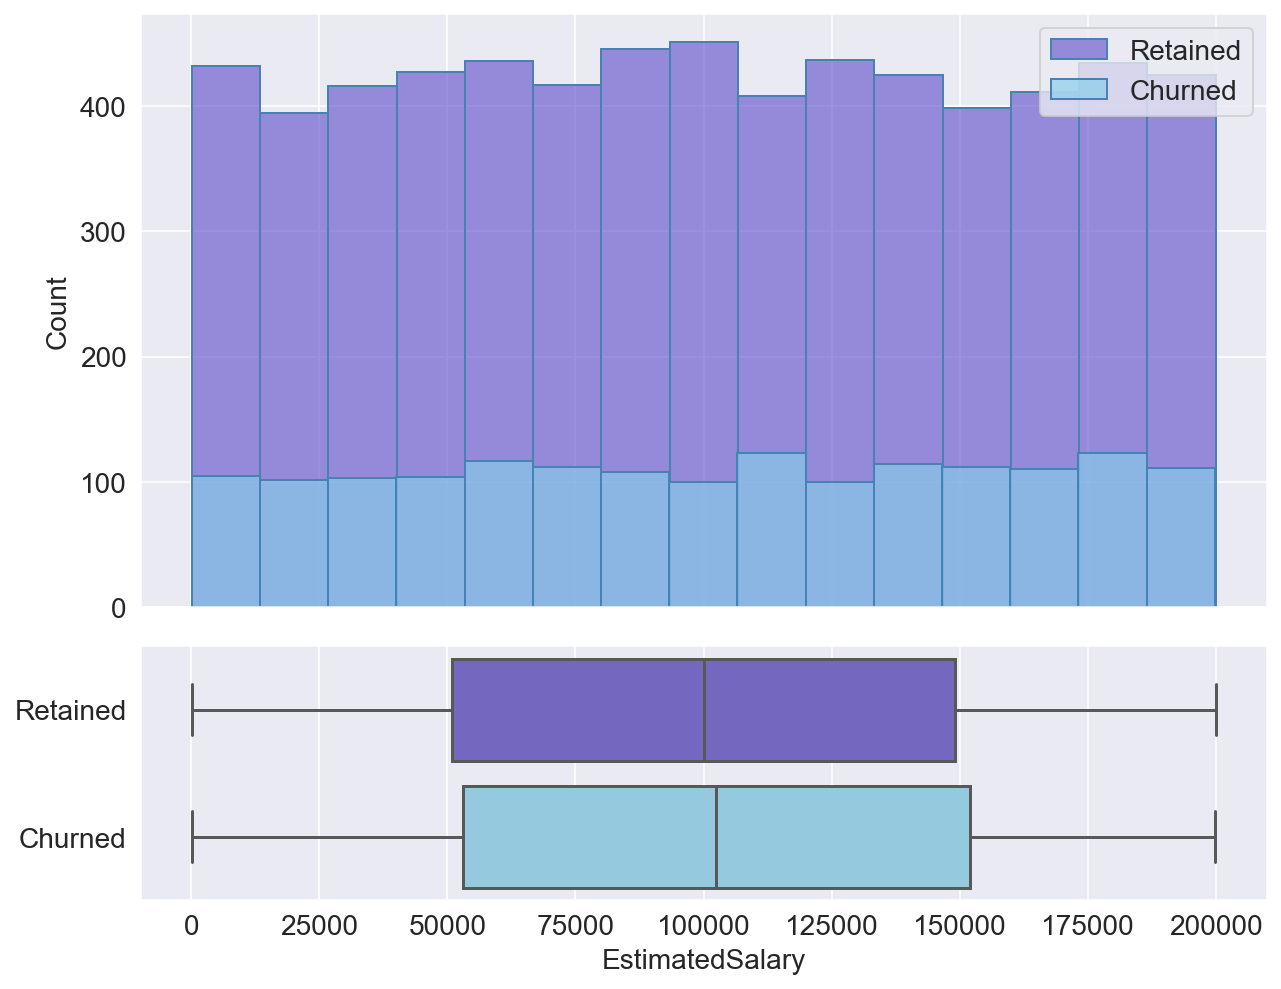

In [23]:
plot_continuous('EstimatedSalary')

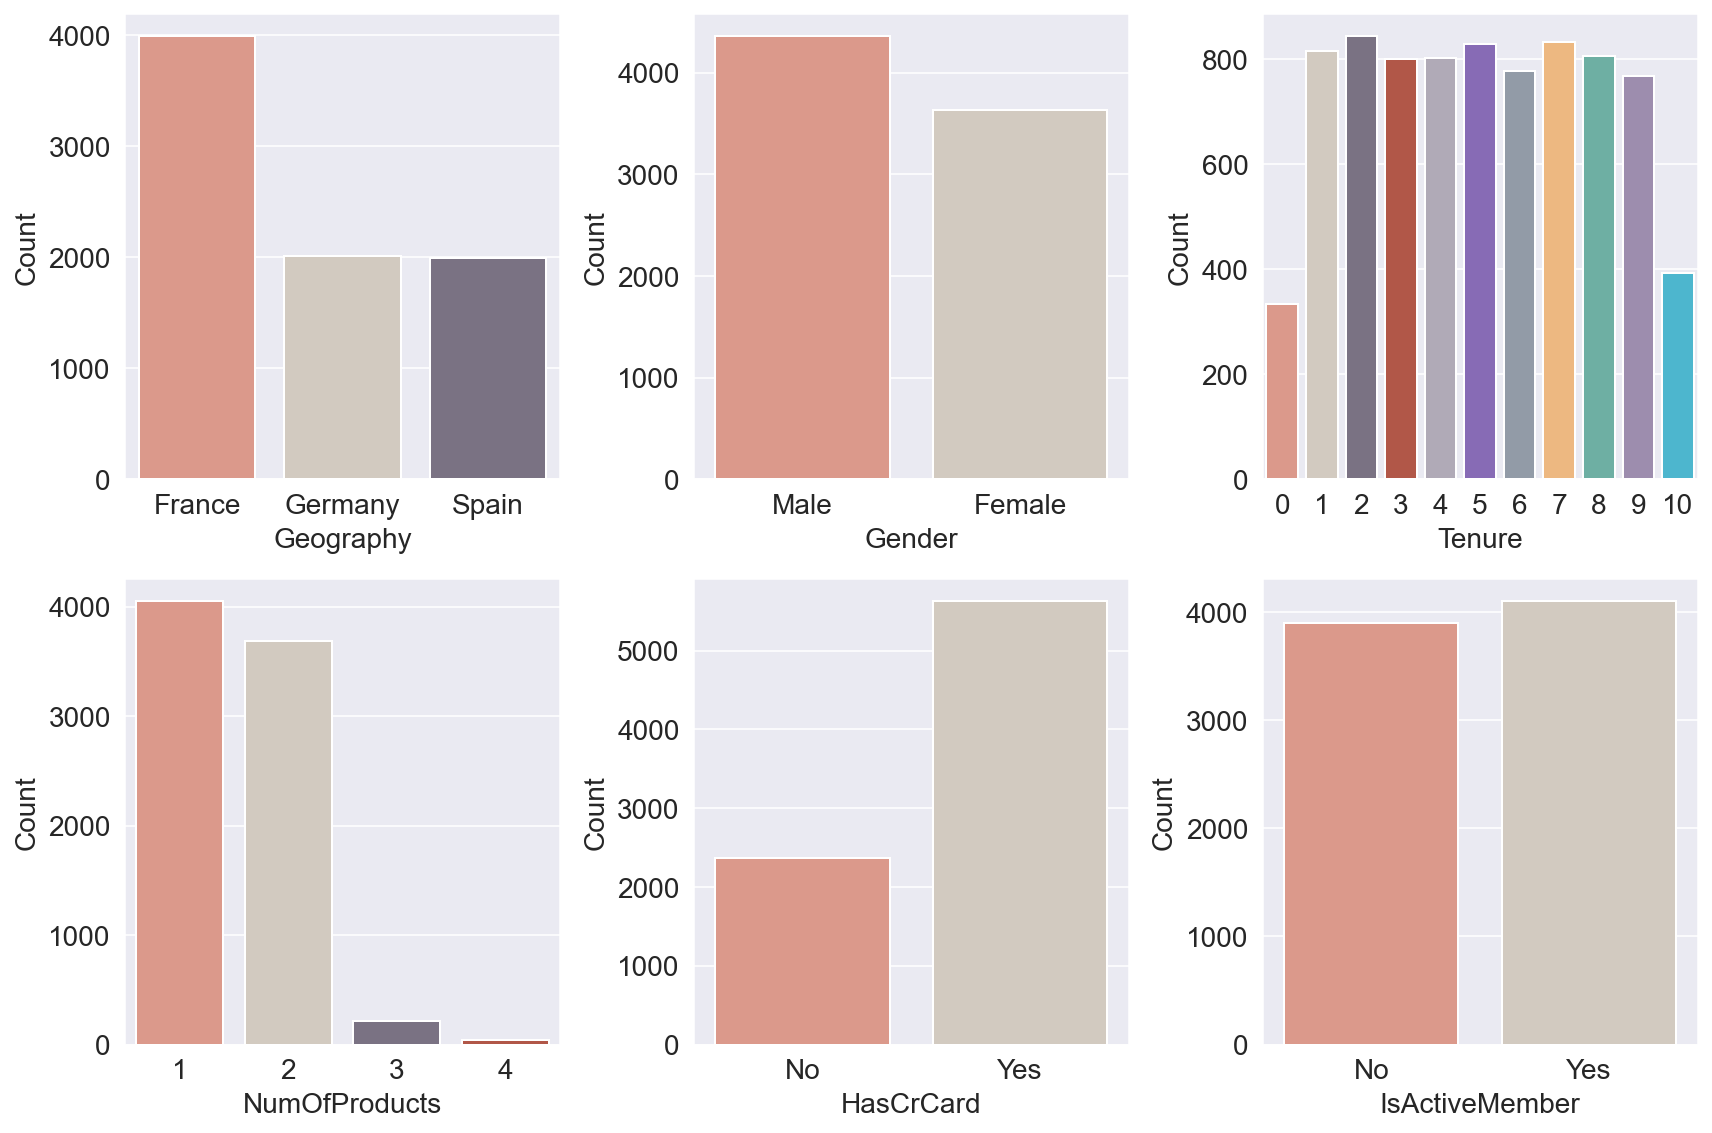

In [24]:
df_cat = train_df[categorical]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=train_df, palette=colors_cat)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

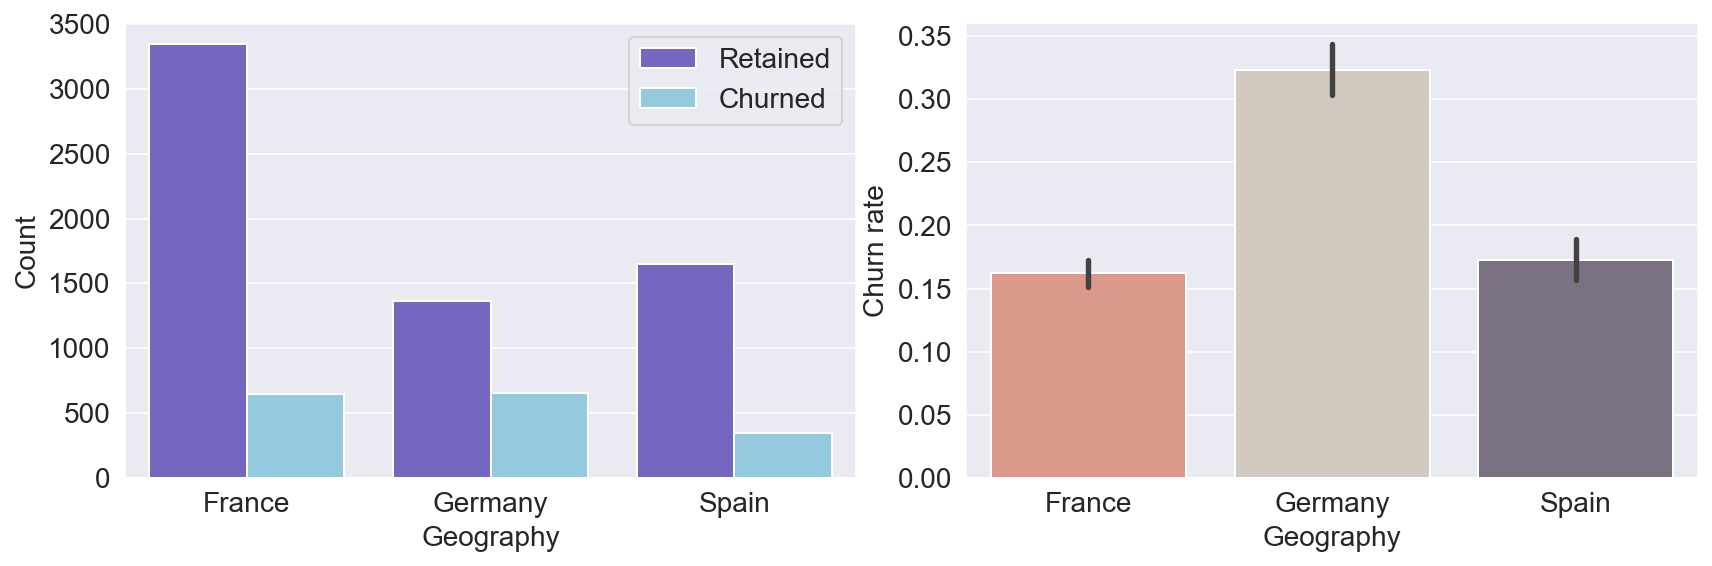

In [25]:
plot_categorical('Geography')

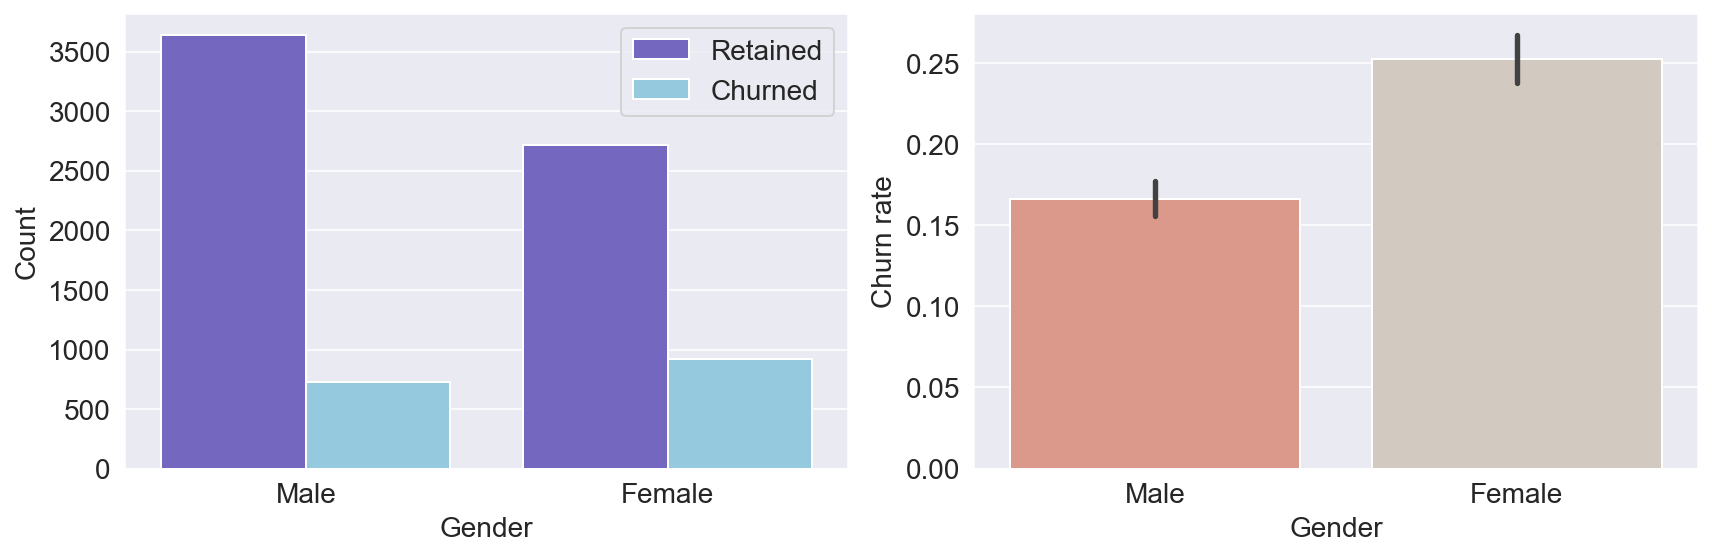

In [26]:
plot_categorical('Gender')

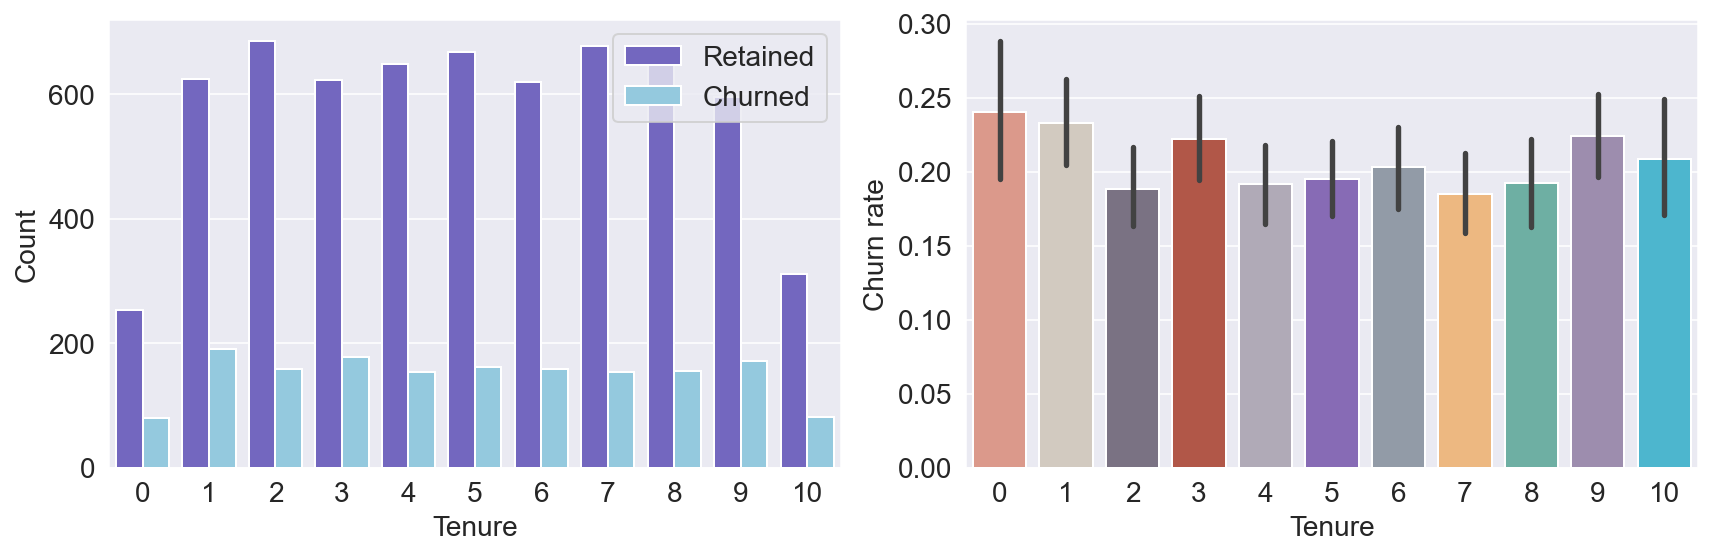

In [27]:
plot_categorical('Tenure')

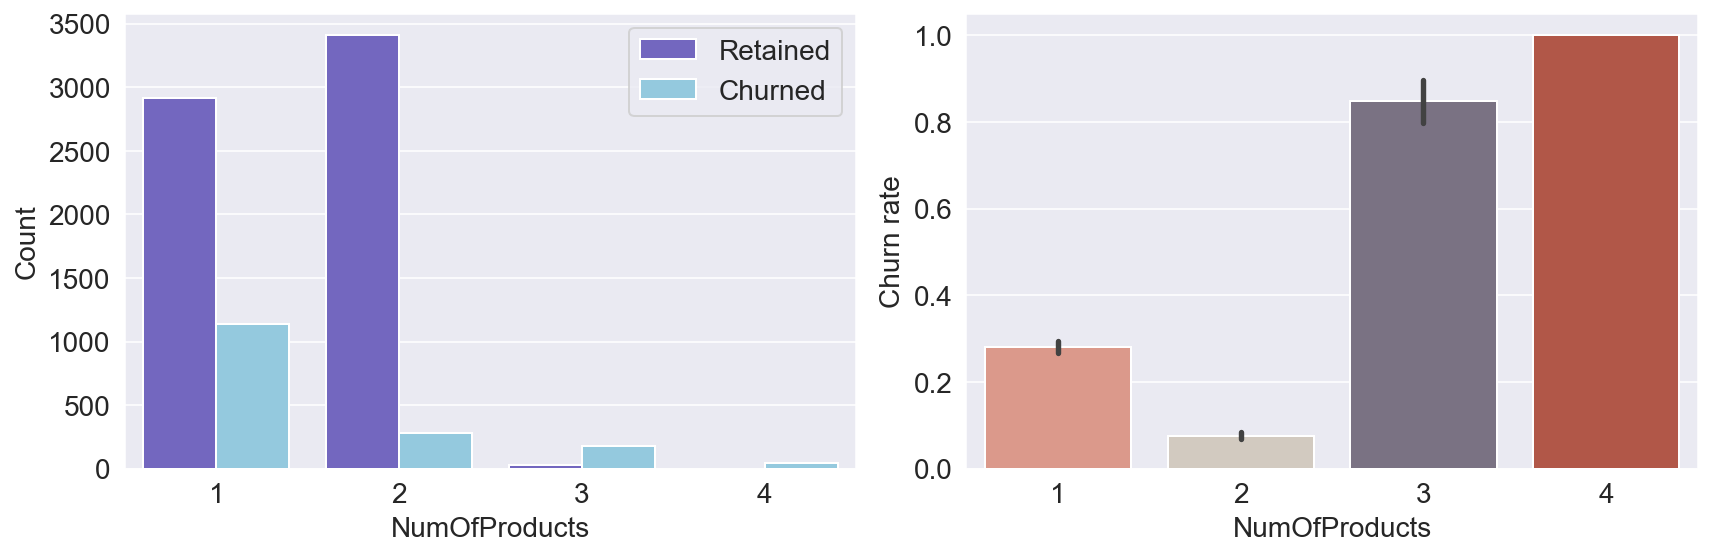

In [28]:
plot_categorical('NumOfProducts')

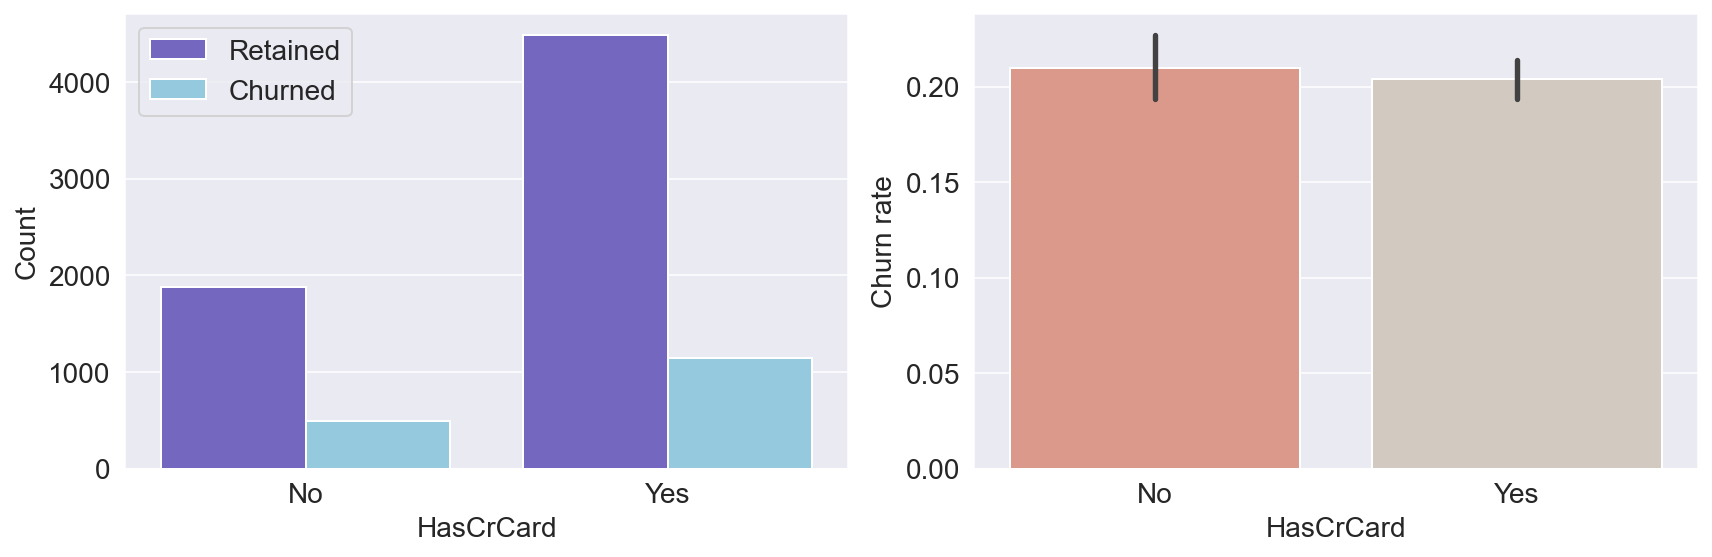

In [29]:
plot_categorical('HasCrCard')

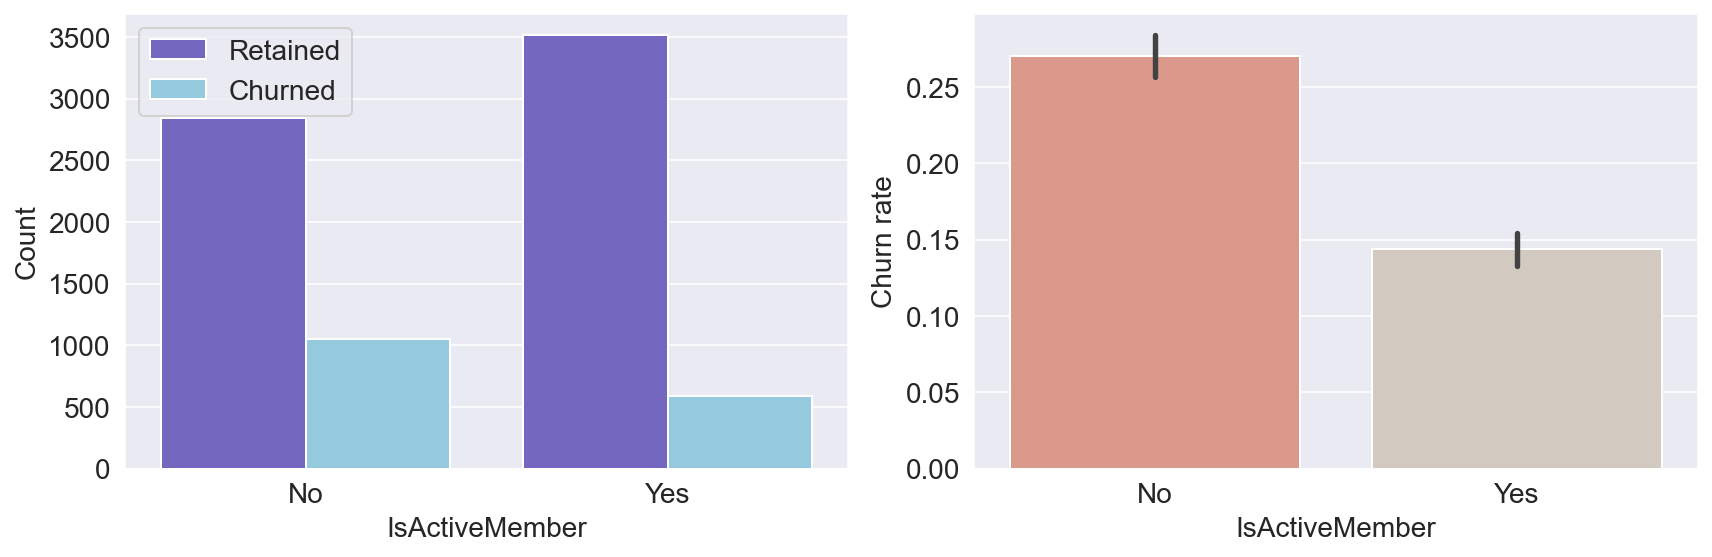

In [30]:
plot_categorical('IsActiveMember')

In [31]:
#Data Prep: eliminate features with little predictive value 

features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df = train_df.drop(features_drop, axis=1)

print('Features Dropped!')

Features Dropped!


In [32]:
#encoding Geo and Gender variables 

train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

print('Features Encoded!')

Features Encoded!


In [33]:
#scaling for class imbalance 
scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

print('Features Scaled!')

Features Scaled!


In [34]:
#creating train set 
y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

print('Sets Created!')

Sets Created!


In [35]:
y_train.value_counts()

0    6356
1    1644
Name: Exited, dtype: int64

In [36]:
#solving for class imbalance in the train set
over = SMOTE(sampling_strategy='auto', random_state=random_state)
X_train, y_train = over.fit_resample(X_train, y_train)

y_train.value_counts()

0    6356
1    6356
Name: Exited, dtype: int64


 Logistic Regression
-------------------------------
   Best Score (recall): 0.73
   Best Parameters: 
      C: 0.001
      max_iter: 100
      penalty: l1
      solver: liblinear


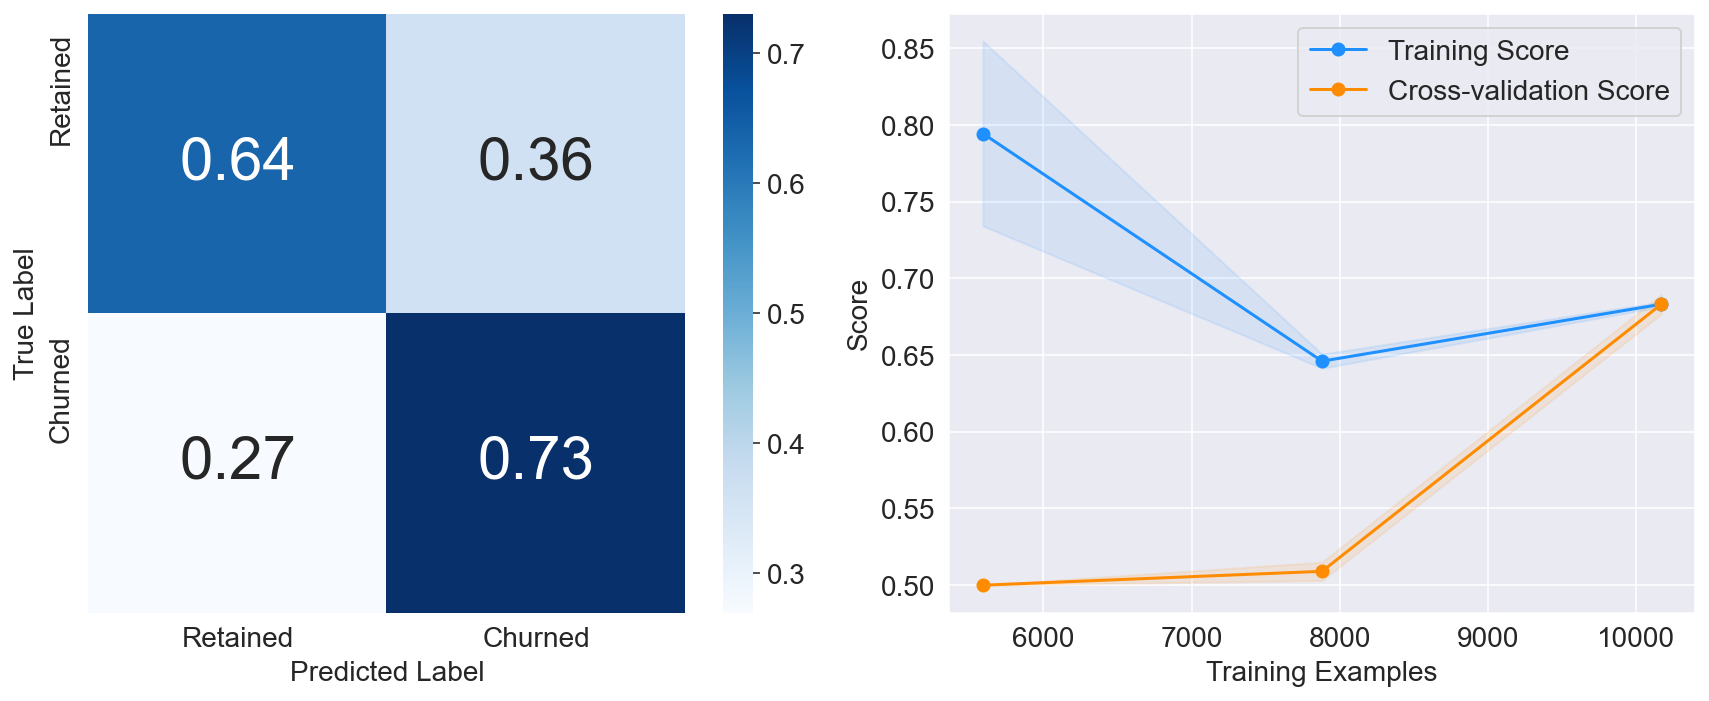

In [37]:
# First model: logistic regression : still deciding if I need the graphs

start=datetime.now()
lr = LogisticRegression(random_state=random_state)

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')
end=datetime.now()

In [38]:
#Interpretbility for LR

start=datetime.now()
lr2 = LogisticRegression(random_state=random_state)

lr_clf2 = lr2.fit(X_train, y_train)
    
#clf_performance(lr_clf2, 'Logistic Regression', 'LR')

importance = lr_clf2.coef_[0]
feat_importances = pd.Series(importance, index=X_train.columns)

print(feat_importances)

end=datetime.now()

CreditScore      -0.08
Geography         0.73
Gender           -0.63
Age               0.84
Balance           0.15
NumOfProducts    -0.22
IsActiveMember   -0.99
dtype: float64


In [39]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:00.017003



 Support Vector Classifier
-------------------------------
   Best Score (recall): 0.696
   Best Parameters: 
      C: 10
      kernel: linear


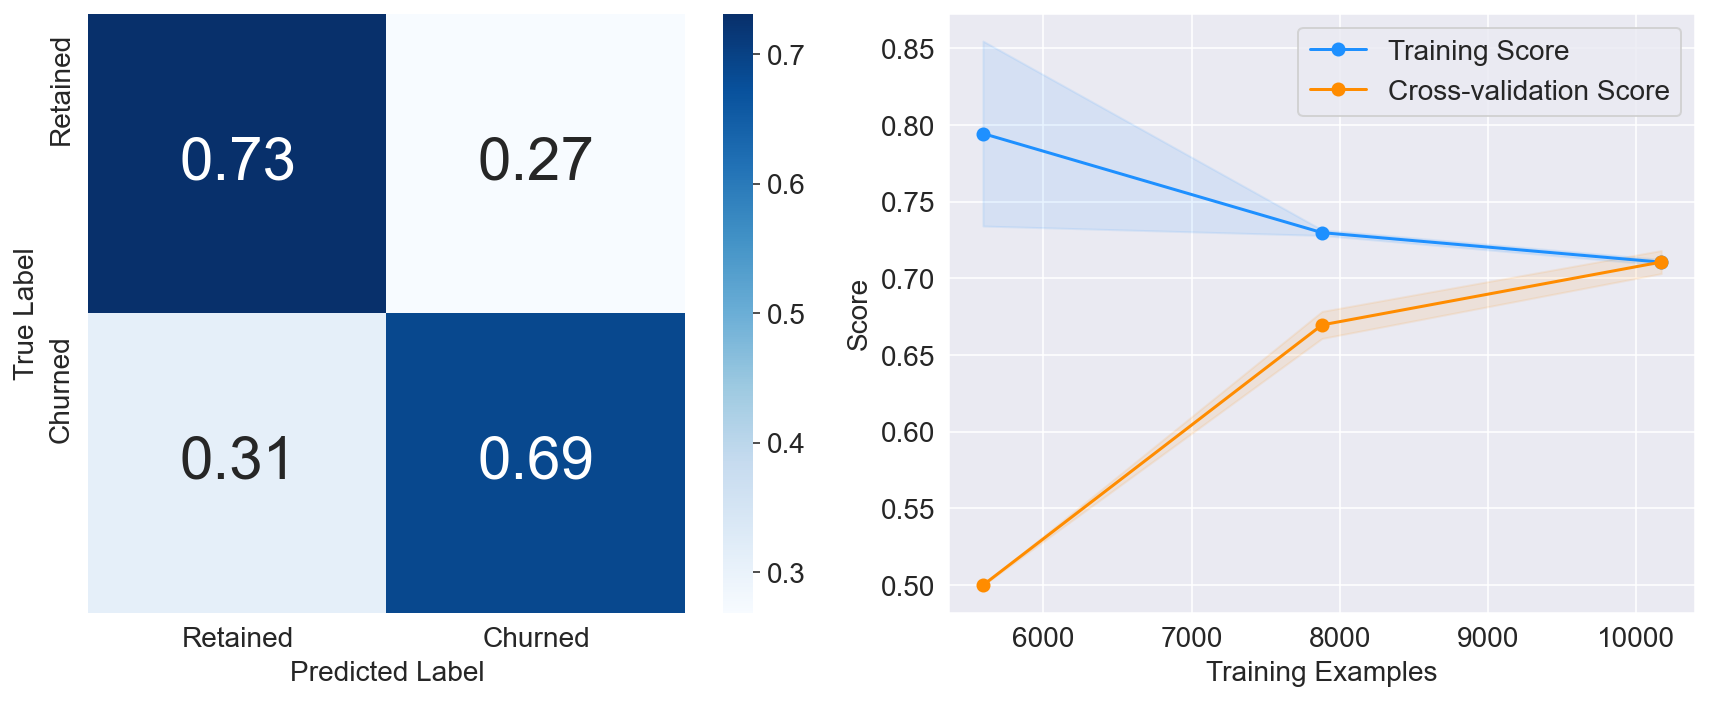

In [40]:
#second model: SVCM

start=datetime.now()

svc = SVC(probability=True, random_state=random_state)

param_grid = tuned_parameters = [
                                 {'kernel': ['linear'],
                                  'C': [.1, 1, 10]}
                                ]

svc_clf = GridSearchCV(estimator=svc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_svc_clf = svc_clf.fit(X_train, y_train)
clf_performance(best_svc_clf, 'Support Vector Classifier', 'SVC')
end=datetime.now()


In [41]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:04:20.643598


In [42]:
#interpretability for SVCM

start=datetime.now()
SVC2 = SVC(probability=True, random_state=random_state, kernel="linear")

SVC_clf2 = SVC2.fit(X_train, y_train)
    
importance = SVC_clf2.coef_[0]
feat_importances = pd.Series(importance, index=X_train.columns)

print(feat_importances)

end=datetime.now()

CreditScore      -0.07
Geography         0.73
Gender           -0.57
Age               0.87
Balance           0.13
NumOfProducts    -0.19
IsActiveMember   -0.79
dtype: float64


In [43]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:25.304640



 Random Forest
-------------------------------
   Best Score (recall): 0.77
   Best Parameters: 
      bootstrap: True
      criterion: gini
      max_depth: 6
      max_features: auto
      min_samples_leaf: 5
      min_samples_split: 2
      n_estimators: 100


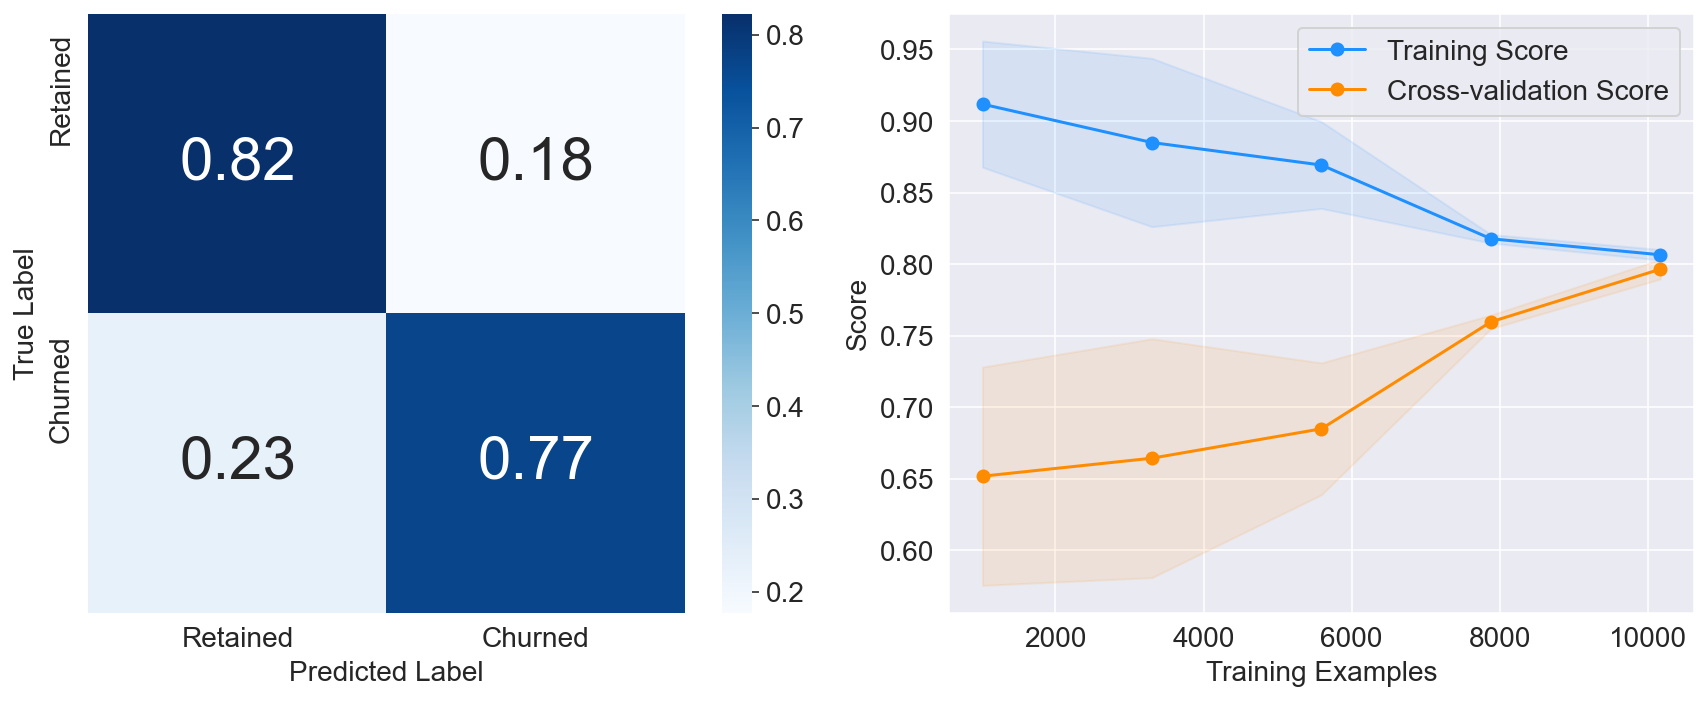

In [44]:
#RF model fit 

start=datetime.now()

rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

end=datetime.now()

In [45]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:25.616639



 Gradient Boosting Classifier
-------------------------------
   Best Score (recall): 0.755
   Best Parameters: 
      learning_rate: 0.01
      max_depth: 3
      max_features: auto
      min_samples_leaf: 3
      min_samples_split: 5
      n_estimators: 600
      n_iter_no_change: 20
      subsample: 0.66
      tol: 0.01
      validation_fraction: 0.2


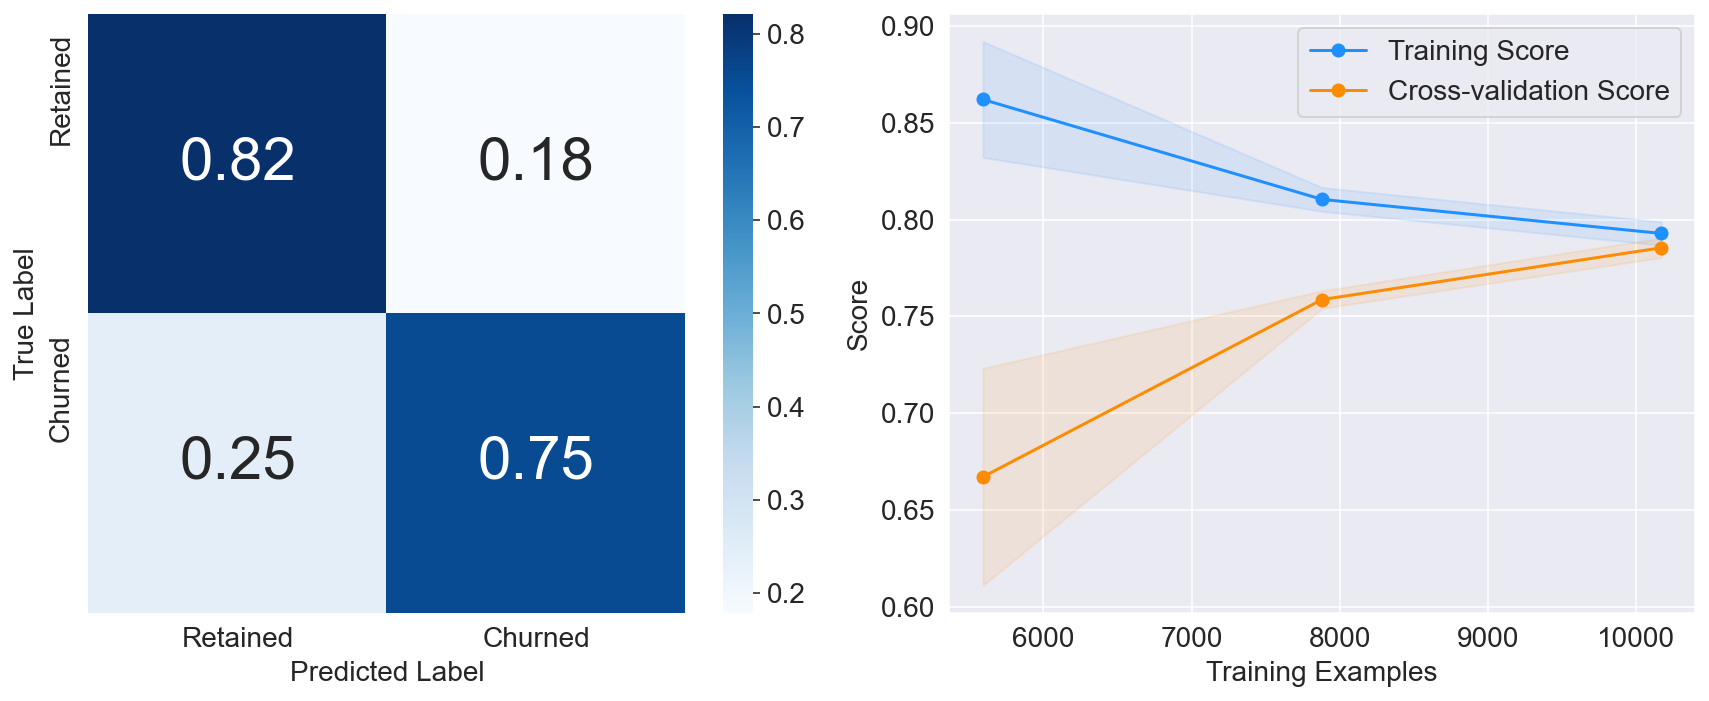

In [46]:
#GBMC model fit

start=datetime.now()

gbc = GradientBoostingClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [600],
    'subsample': [0.66, 0.75],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3],  
    'min_samples_split': [5, 7],
    'min_samples_leaf': [3, 5],
    'max_features': ['auto', 'log2', None],
    'n_iter_no_change': [20],
    'validation_fraction': [0.2],
    'tol': [0.01]
}

gbc_clf = GridSearchCV(estimator=gbc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_gbc_clf = gbc_clf.fit(X_train, y_train)
clf_performance(best_gbc_clf, 'Gradient Boosting Classifier', 'GBC')

end=datetime.now()

In [47]:
best_gbc_clf.best_estimator_.n_estimators_

284

In [48]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:33.787610


[18:28:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.785
   Best Parameters: 
      colsample_bytree: 0.5
      gamma: 1
      learning_rate: 0.001
      max_depth: 4
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 1
      reg_lambda: 1
      subsample: 0.75
[18:28:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default

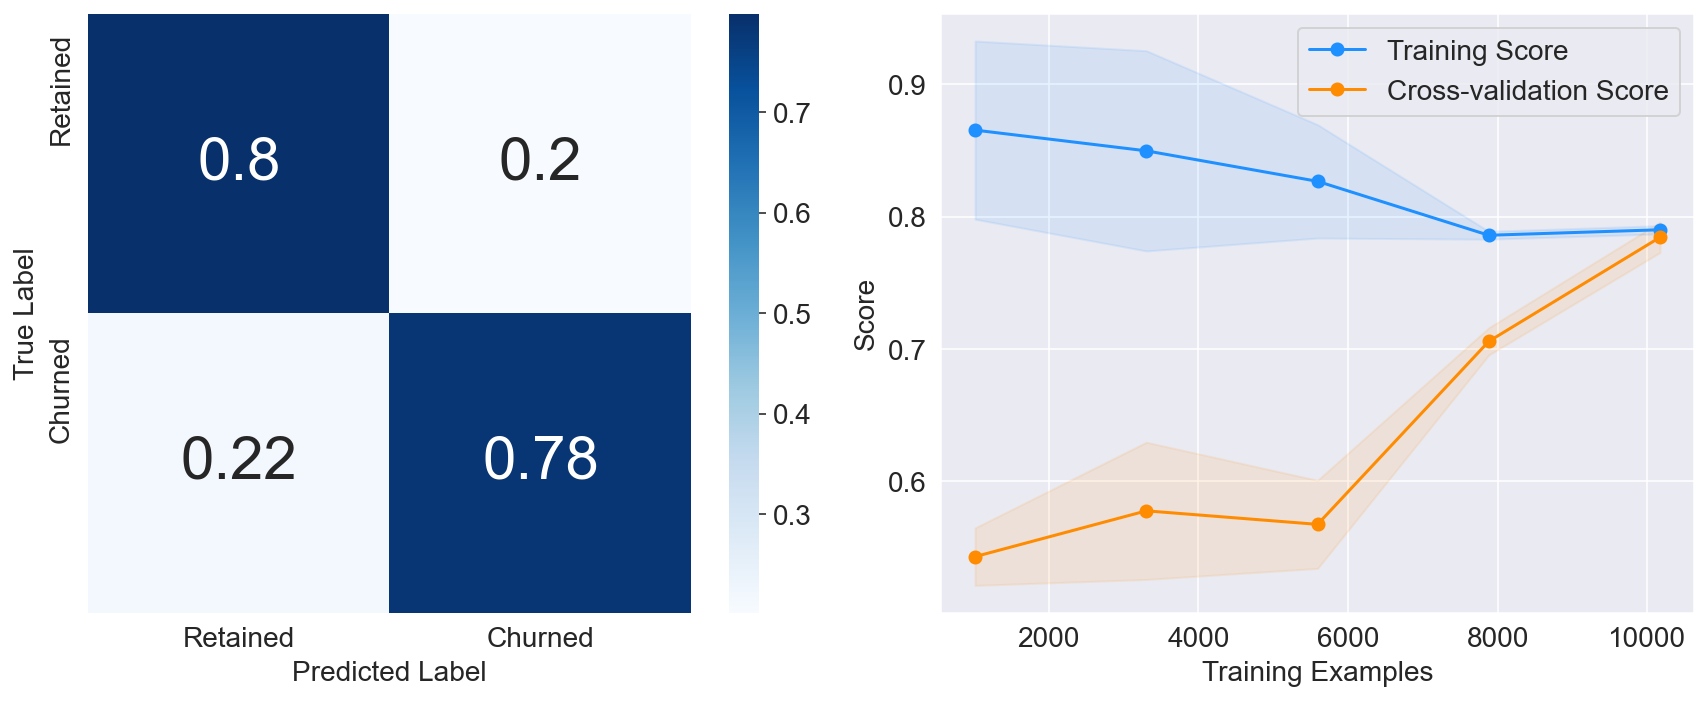

In [49]:
#XGBMC fit

start=datetime.now()
xgb = XGBClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 4],  
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=xgb,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')
end=datetime.now()

In [50]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:45.486611


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5

 LGBMClassifier
-------------------------------
   Best Score (recall): 0.779
   Best Parameters: 
      feature_fraction: 0.5
      learning_rate: 0.01
      max_depth: 5
      min_child_samples: 10
      n_estimators: 200
      num_leaves: 10
      reg_alpha: 0.1
      reg_lambda: 0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


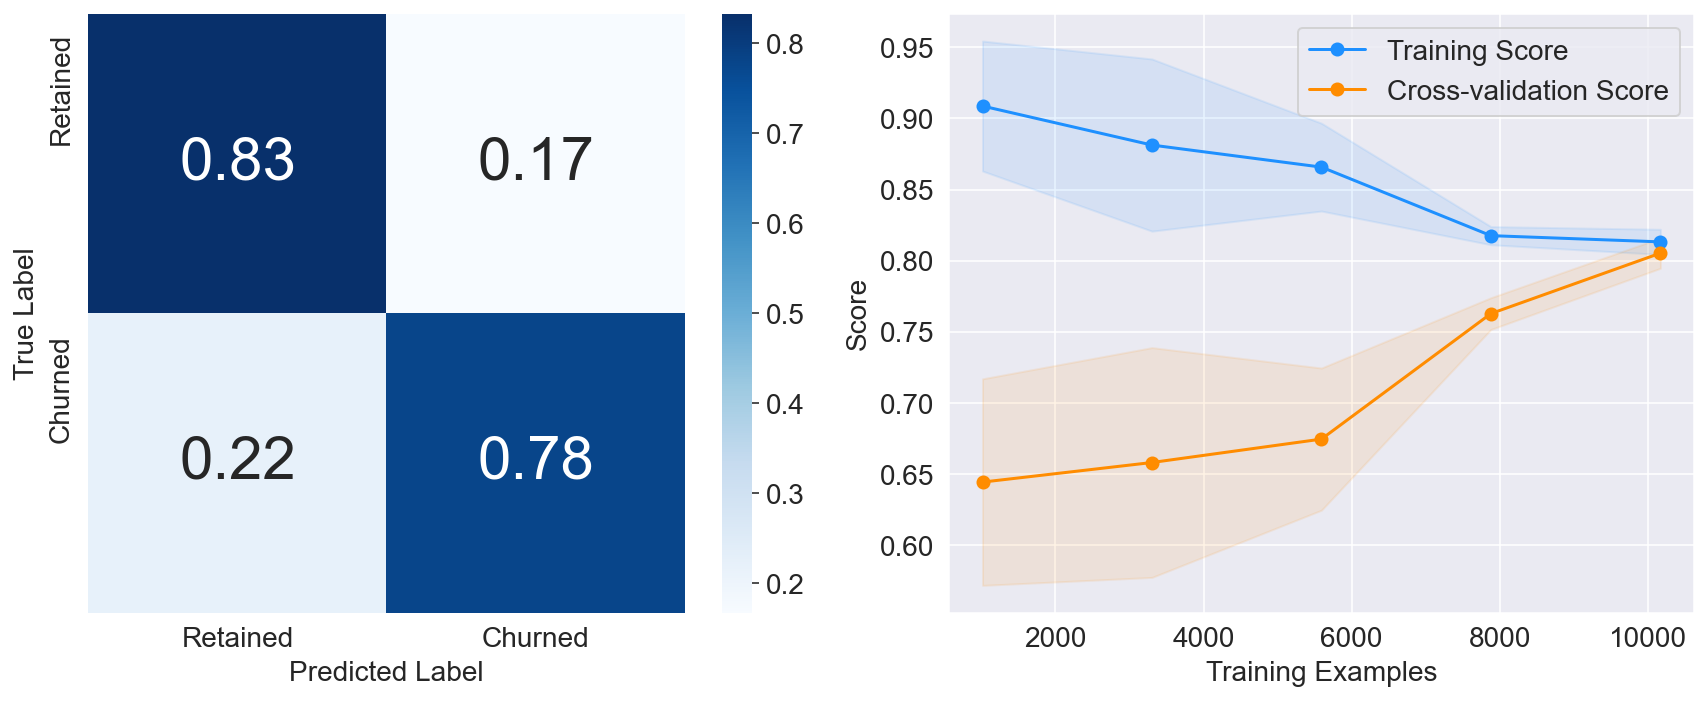

In [51]:
#LGBMC fit
start=datetime.now()

lgbmc = LGBMClassifier(random_state=random_state)

param_grid = {
    'max_depth': [5],
    'num_leaves': [5, 10],
    'learning_rate': [0.001, 0.01],
    'n_estimators': [200],
    'feature_fraction': [0.5],
    'min_child_samples': [5, 10],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

lgbmc_clf = GridSearchCV(estimator=lgbmc,
                         param_grid=param_grid,
                         scoring=scoring_metric,
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

best_lgbmc_clf = lgbmc_clf.fit(X_train, y_train)
clf_performance(best_lgbmc_clf, 'LGBMClassifier', 'LGBMC')

end=datetime.now()

In [52]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:11.756624


Soft Voting
-----------------
  Recall:  0.763


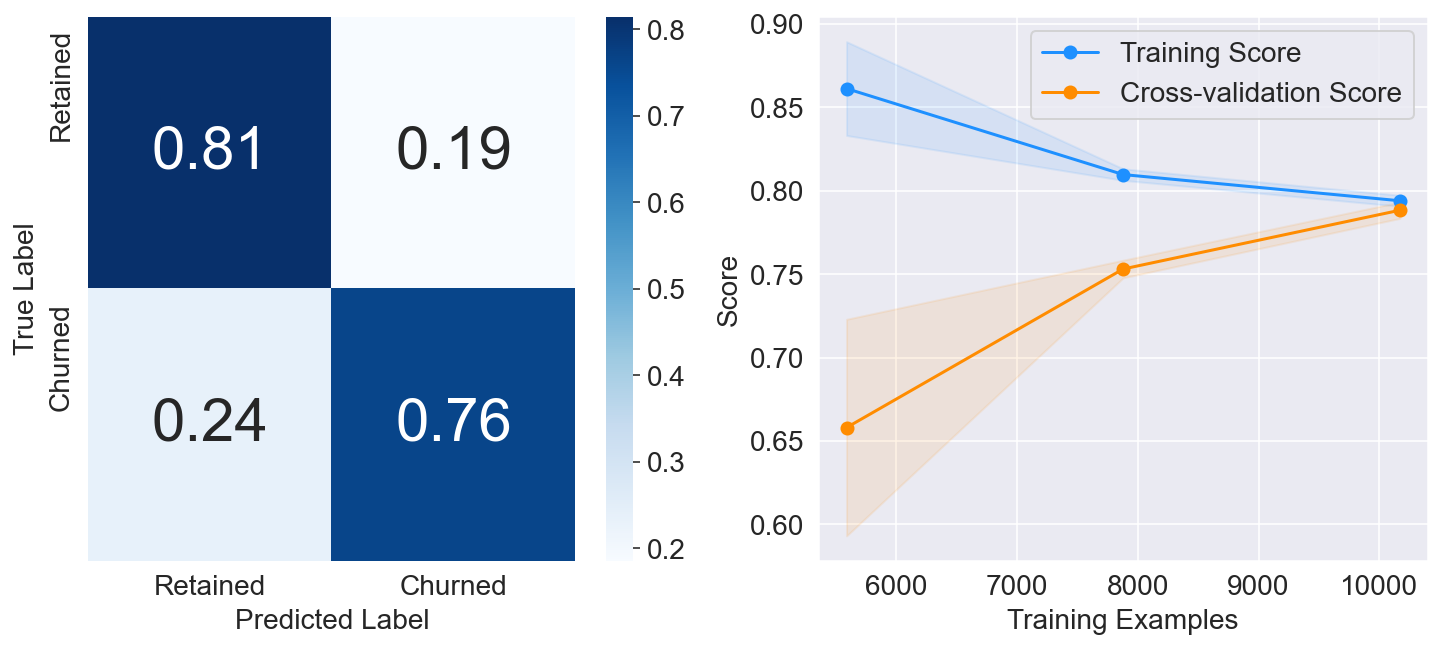

In [53]:
#softvoting for better model fit

estimators = [('LR', best_lr_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('GBC', best_gbc_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_),
              ('LGBMC', best_lgbmc_clf.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators=estimators[1:],
                                     voting='soft',
                                     n_jobs=-1)
estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft,
                              X_train,
                              y_train,
                              cv=5,
                              method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize='true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [
    accuracy_score(y_train, y_pred),
    precision_score(y_train, y_pred),
    recall_score(y_train, y_pred),
    roc_auc_score(y_train, y_pred_pp), fpr, tpr
]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_conf_mx(cm, ax1)
plot_learning_curve(tuned_voting_soft, X_train, y_train, ax2)

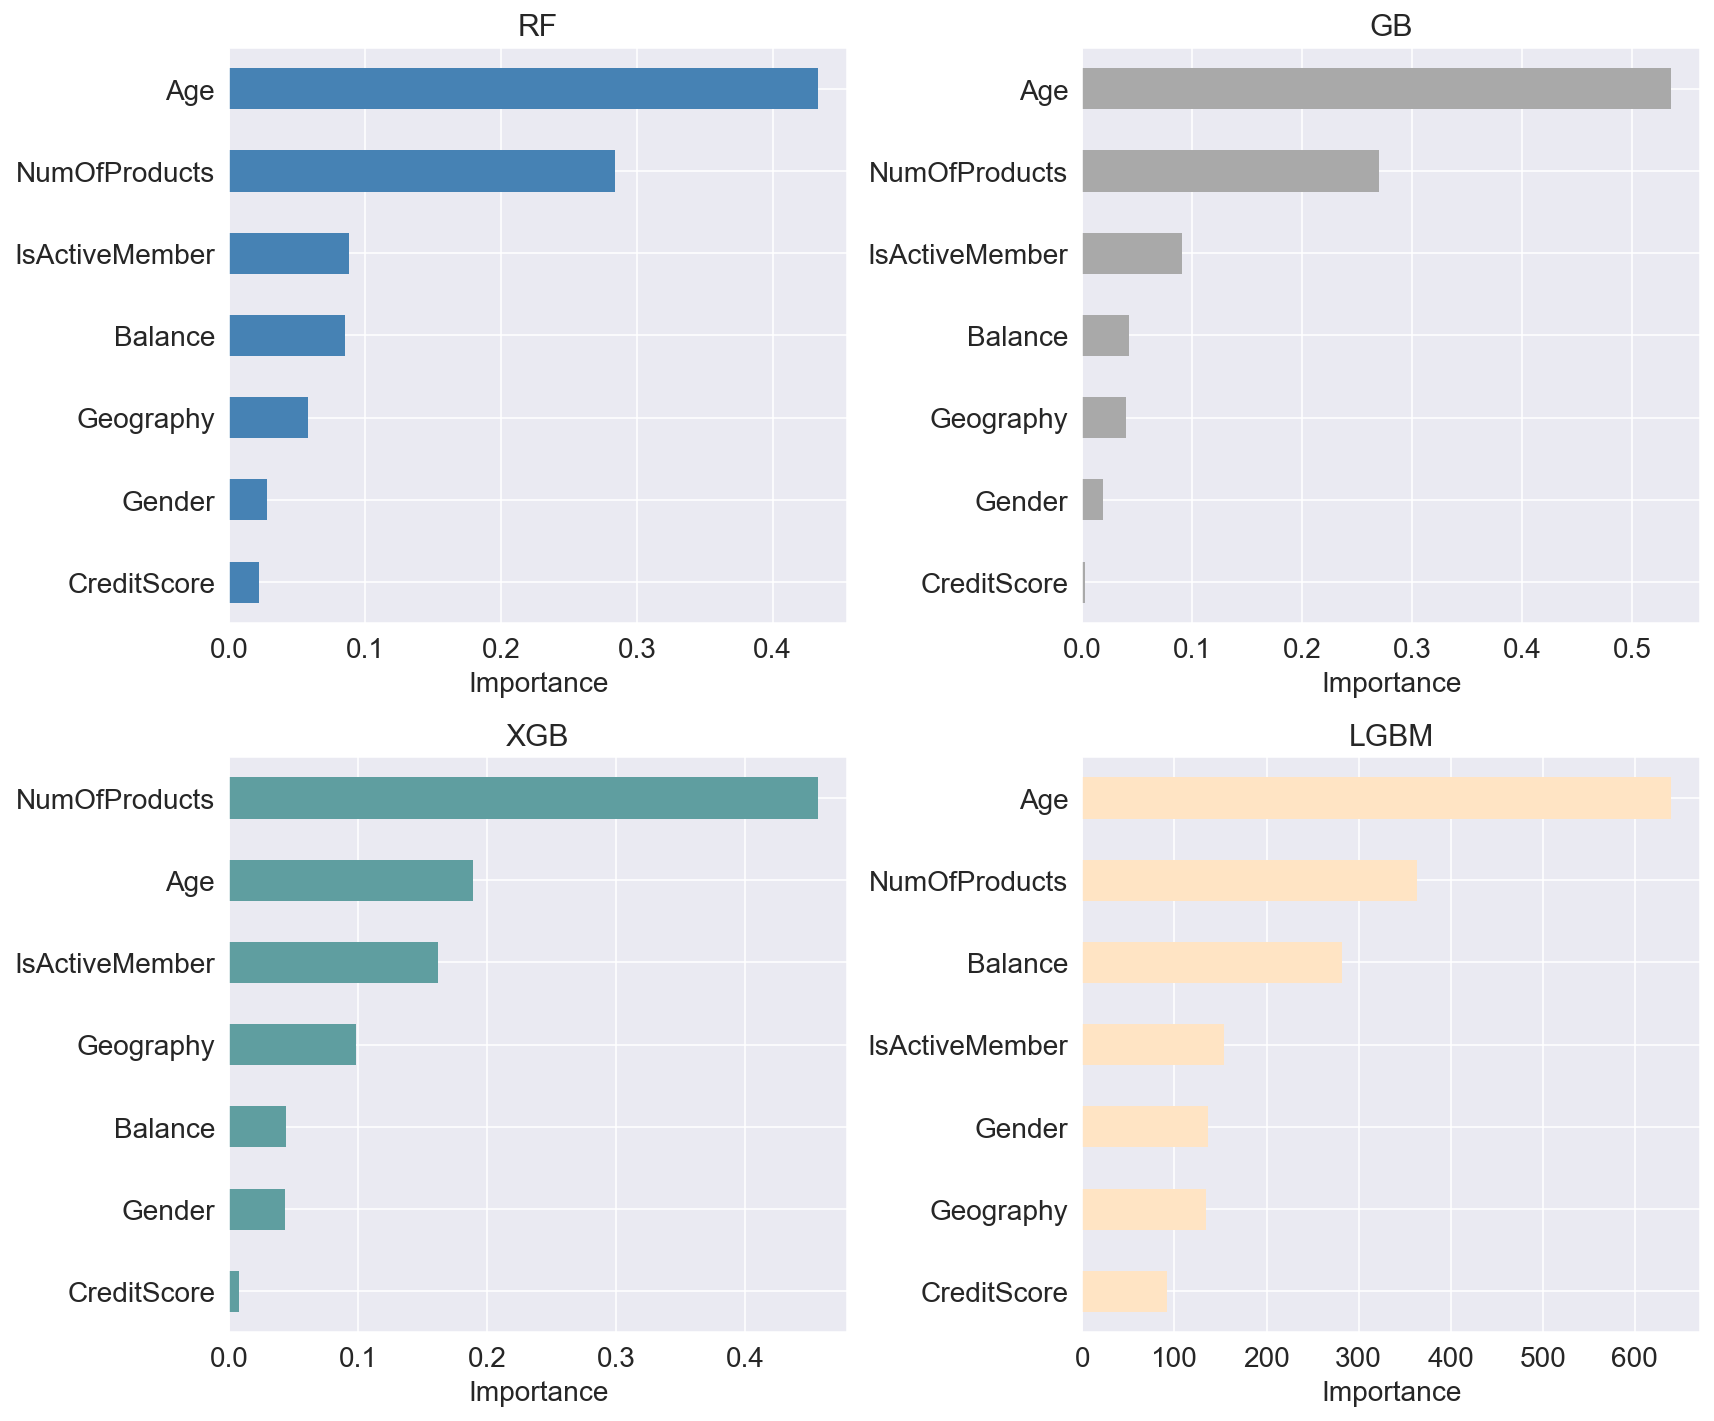

In [54]:

#Feature importance     
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig = plt.subplots(2, 2, figsize=(12, 10))

for i, (name, clf) in enumerate(zip(['RF', 'GB', 'XGB', 'LGBM'],
                                    [best_rf_clf, best_gbc_clf, best_xgb_clf, best_lgbmc_clf])):

    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, colors_fi[i], ax)
    plt.ylabel('')

plt.tight_layout();

In [55]:
#Feature importance for Random Forest 
importances2 = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(best_rf_clf.best_estimator_.feature_importances_, 3)})

importances2 = importances2.sort_values('Importance', ascending=True).set_index('Feature')

print(importances2)

                Importance
Feature                   
CreditScore           0.02
Gender                0.03
Geography             0.06
Balance               0.09
IsActiveMember        0.09
NumOfProducts         0.28
Age                   0.43


In [56]:
#Feature importance for GBMC

importances2 = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(best_gbc_clf.best_estimator_.feature_importances_, 4)})

importances2 = importances2.sort_values('Importance', ascending=True).set_index('Feature')

print(importances2)

                Importance
Feature                   
CreditScore       2.10e-03
Gender            1.94e-02
Geography         4.05e-02
Balance           4.20e-02
IsActiveMember    9.11e-02
NumOfProducts     2.70e-01
Age               5.35e-01


In [57]:
#Feature importance for XGBMC
importances2 = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(best_xgb_clf.best_estimator_.feature_importances_, 4)})

importances2 = importances2.sort_values('Importance', ascending=True).set_index('Feature')

print(importances2)

                Importance
Feature                   
CreditScore       8.50e-03
Gender            4.25e-02
Balance           4.43e-02
Geography         9.76e-02
IsActiveMember    1.62e-01
Age               1.89e-01
NumOfProducts     4.56e-01


In [58]:
#Feature importance for LGBMC
importances2 = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(best_lgbmc_clf.best_estimator_.feature_importances_, 4)})

importances2 = importances2.sort_values('Importance', ascending=True).set_index('Feature')

print(importances2)

                Importance
Feature                   
CreditScore             92
Geography              134
Gender                 136
IsActiveMember         154
Balance                282
NumOfProducts          363
Age                    639


In [59]:
#Comparison across prediction metrics

comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

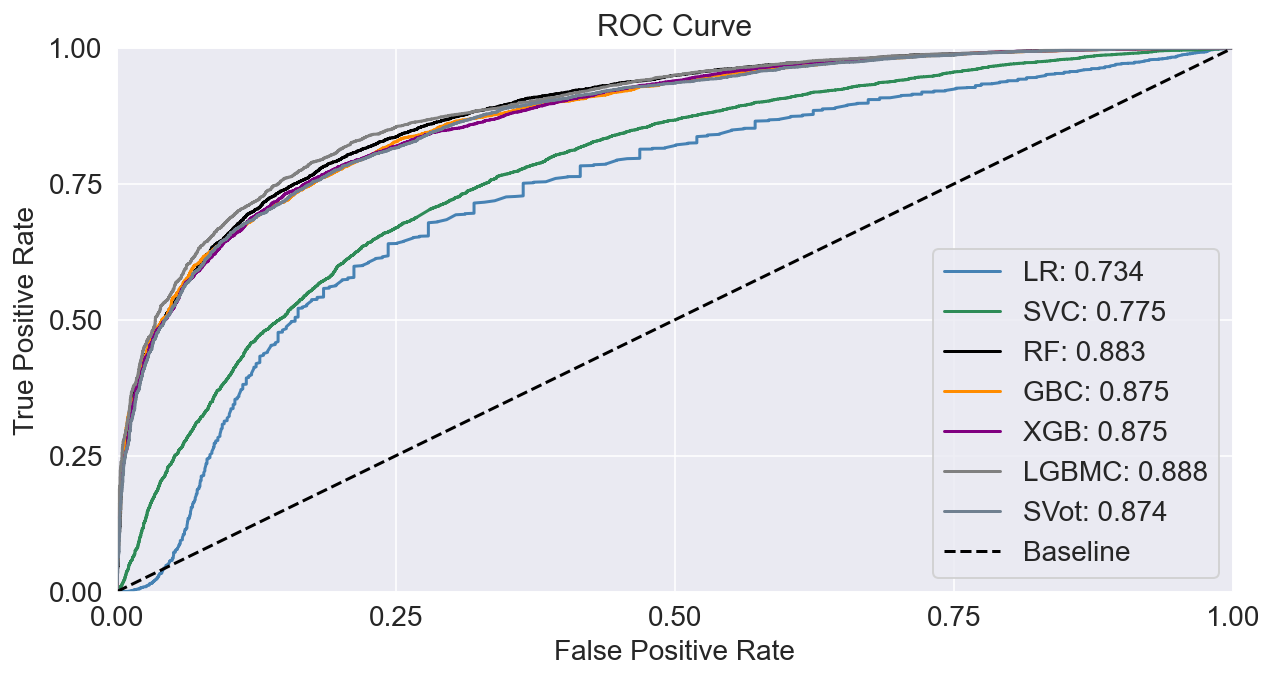

In [60]:
#Lets ROC'n'roll all night! 

fig, ax = plt.subplots(figsize=(10, 5))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    ax.plot(fpr,
            tpr,
            color=colors_comp[index],
            label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('True Positive Rate')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=14);

In [61]:
#Proof in the pudding, the test set 

test_df = test_df.drop(features_drop, axis=1)

test_df['Gender'] = LabelEncoder().fit_transform(test_df['Gender'])
test_df['Geography'] = test_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

test_df[scl_columns] = scaler.transform(test_df[scl_columns])  # not fit_transform, scaler has already been trained

y_test = test_df['Exited']
X_test = test_df.drop('Exited', 1)

print('Preprocessing Complete!')

Preprocessing Complete!


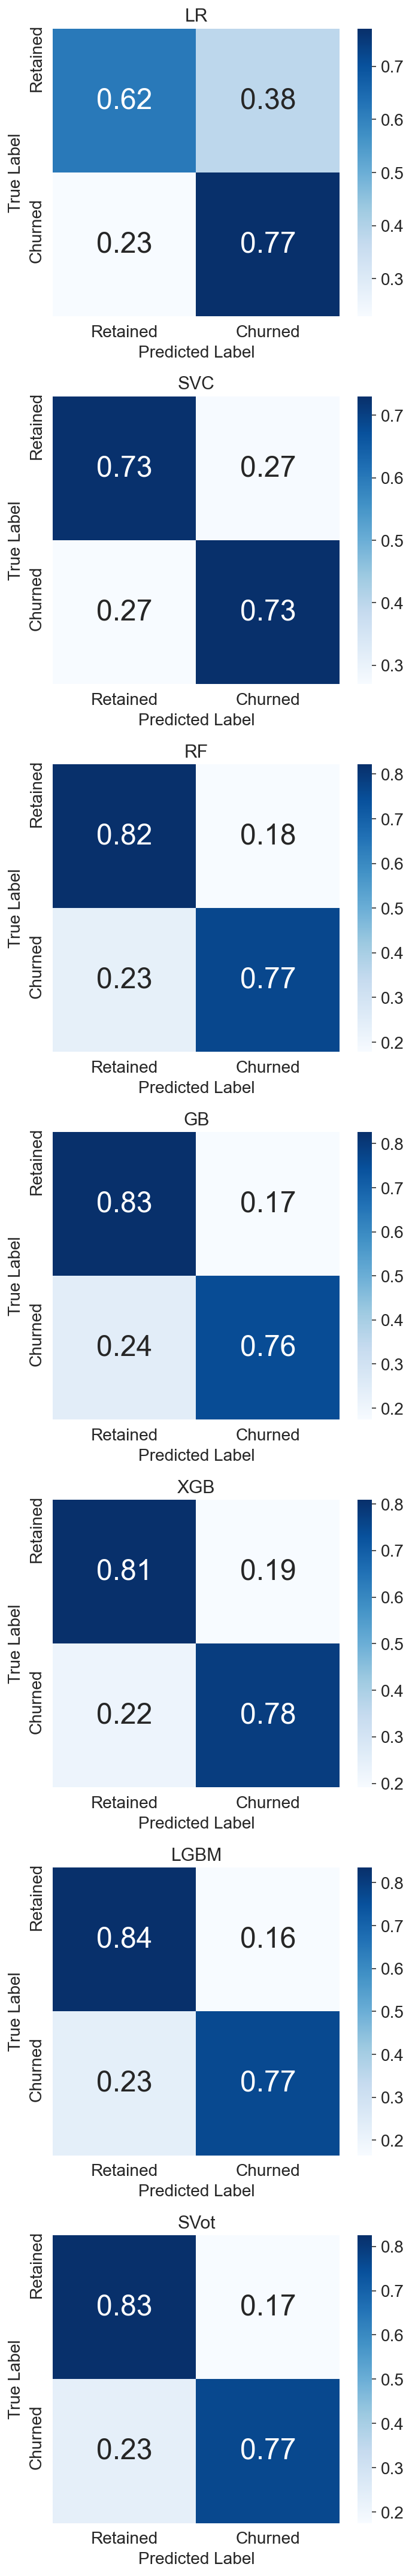

In [62]:
#fitting all models on test set

tuned_voting_soft.fit(X_train, y_train)

fig, ax = plt.subplots(7, 1, figsize=(5, 30))

for i, (name, clf) in enumerate(zip(['LR', 'SVC', 'RF', 'GB', 'XGB', 'LGBM', 'SVot'], 
                                    [best_lr_clf.best_estimator_, best_svc_clf.best_estimator_, best_rf_clf.best_estimator_, best_gbc_clf.best_estimator_, best_xgb_clf.best_estimator_, best_lgbmc_clf.best_estimator_, tuned_voting_soft])):
    test_func(clf, name, ax=ax[i])

plt.tight_layout();

In [63]:
#Comparison results in the test set 

comparison_test_df = pd.DataFrame(comparison_test_dict,
                                  index=['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color='indianred', axis=0)

In [64]:
#-----analysis for 1k segment

#importing dataset

df = pd.read_csv('C:/Users/luisb/iCloudDrive/Documents/Documents/MSPA-New/Capstone Project/Churn_Modeling_3.csv')

print('Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

Dataset Imported Successfully!

It contains 1000 rows and 14 columns.


RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0   3.63e-05    15751120      Loyau          752    France  Female   36   
1   1.41e-04    15648725   Sinclair          660    France    Male   41   
2   4.95e-04    15656627        Lin          602    France    Male   34   
3   6.30e-04    15695932  Yelverton          766     Spain    Male   36   
4   6.76e-04    15716024     Dennis          660     Spain    Male   42   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2  119912.46              1          1               0   
1       3       0.00              2          1               1   
2       5       0.00              2          1               1   
3       5   78381.13              1          0               1   
4       5       0.00              2          1               0   

   EstimatedSalary  Exited  
0        124354.92       0  
1        108665.89       0  
2         77414.45       0  
3        153831.60       0  
4        115509.59       0

In [65]:
#dropping useless columns
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [66]:
#looking into feature types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      1000 non-null   int64  
 1   Geography        1000 non-null   object 
 2   Gender           1000 non-null   object 
 3   Age              1000 non-null   int64  
 4   Tenure           1000 non-null   int64  
 5   Balance          1000 non-null   float64
 6   NumOfProducts    1000 non-null   int64  
 7   HasCrCard        1000 non-null   int64  
 8   IsActiveMember   1000 non-null   int64  
 9   EstimatedSalary  1000 non-null   float64
 10  Exited           1000 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 86.1+ KB


In [67]:
#useufl stats
df.describe()

CreditScore      Age   Tenure    Balance  NumOfProducts  HasCrCard  \
count      1000.00  1000.00  1000.00    1000.00        1000.00    1000.00   
mean        651.27    38.98     5.03   75338.82           1.54       0.67   
std          97.71    10.42     2.83   62928.36           0.60       0.47   
min         359.00    18.00     0.00       0.00           1.00       0.00   
25%         583.00    32.00     3.00       0.00           1.00       0.00   
50%         653.50    37.50     5.00   95340.12           1.00       1.00   
75%         717.00    44.00     7.00  128717.40           2.00       1.00   
max         850.00    88.00    10.00  250898.09           4.00       1.00   

       IsActiveMember  EstimatedSalary   Exited  
count         1000.00          1000.00  1000.00  
mean             0.51        101444.09     0.21  
std              0.50         56911.71     0.41  
min              0.00            96.27     0.00  
25%              0.00         54658.25     0.00  
50%              1.00        101353.49     0.00  
75%              1.00        150251.06     0.00  
max              1.00        199693.84     1.00

In [68]:
#creating train/test set 

train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print('Train set: {} rows x {} columns'.format(train_df.shape[0],
                                               train_df.shape[1]))
print(' Test set: {} rows x {} columns'.format(test_df.shape[0],
                                               test_df.shape[1]))

Train set: 800 rows x 11 columns
 Test set: 200 rows x 11 columns


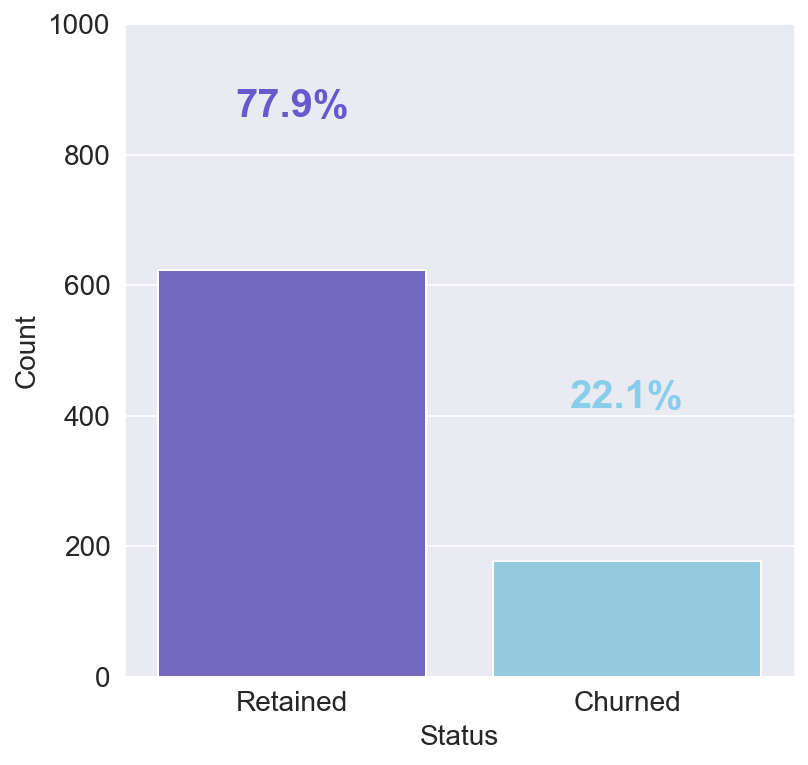

In [69]:
#EDA - target variable "exited"
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=train_df, palette=colors, ax=ax)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label = '{}%'.format(round((value / train_df['Exited'].shape[0]) * 100, 1))
    ax.annotate(label,
                xy=(index, value + 250),
                ha='center',
                va='center',
                color=colors[index],
                fontweight='bold',
                size=font_size + 6)

ax.set_xticklabels(['Retained', 'Churned'])
ax.set_xlabel('Status')
ax.set_ylabel('Count')
ax.set_ylim([0, 1000]);

In [70]:
#defining array for analysis between continuos and categoricla values

continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


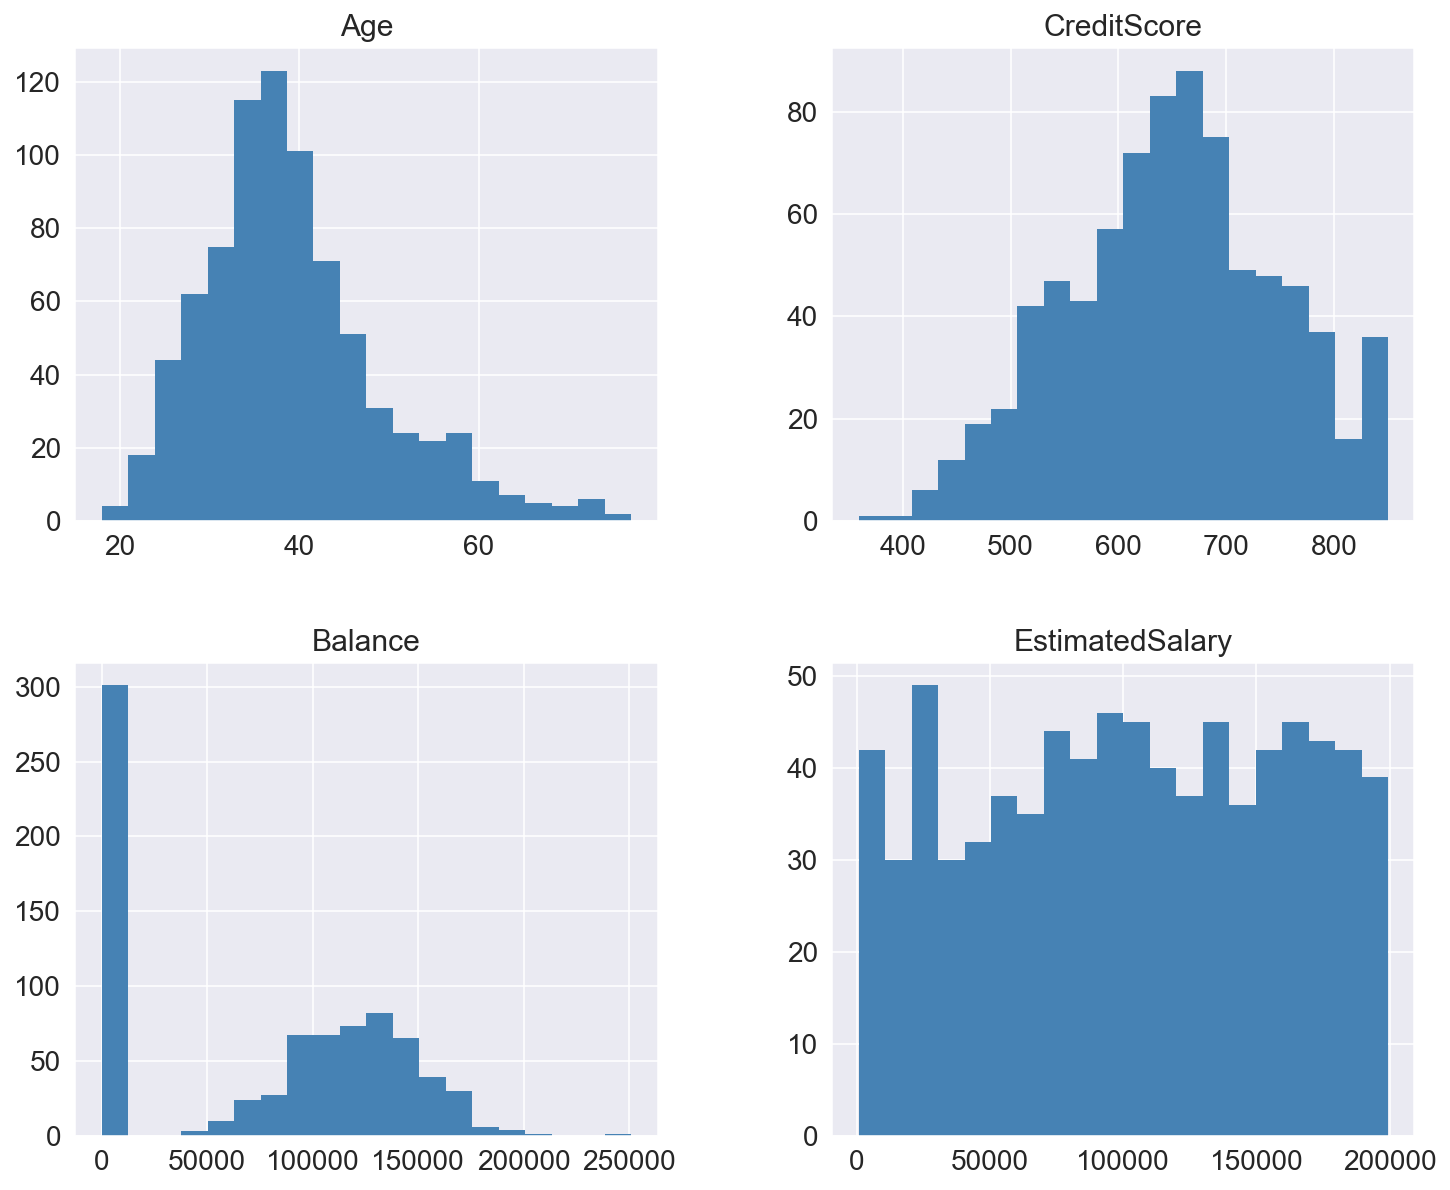

In [71]:
#Continuous variables
train_df[continuous].hist(figsize=(12, 10),
                          bins=20,
                          layout=(2, 2),
                          color='steelblue',
                          edgecolor='none',
                          linewidth=1.5);

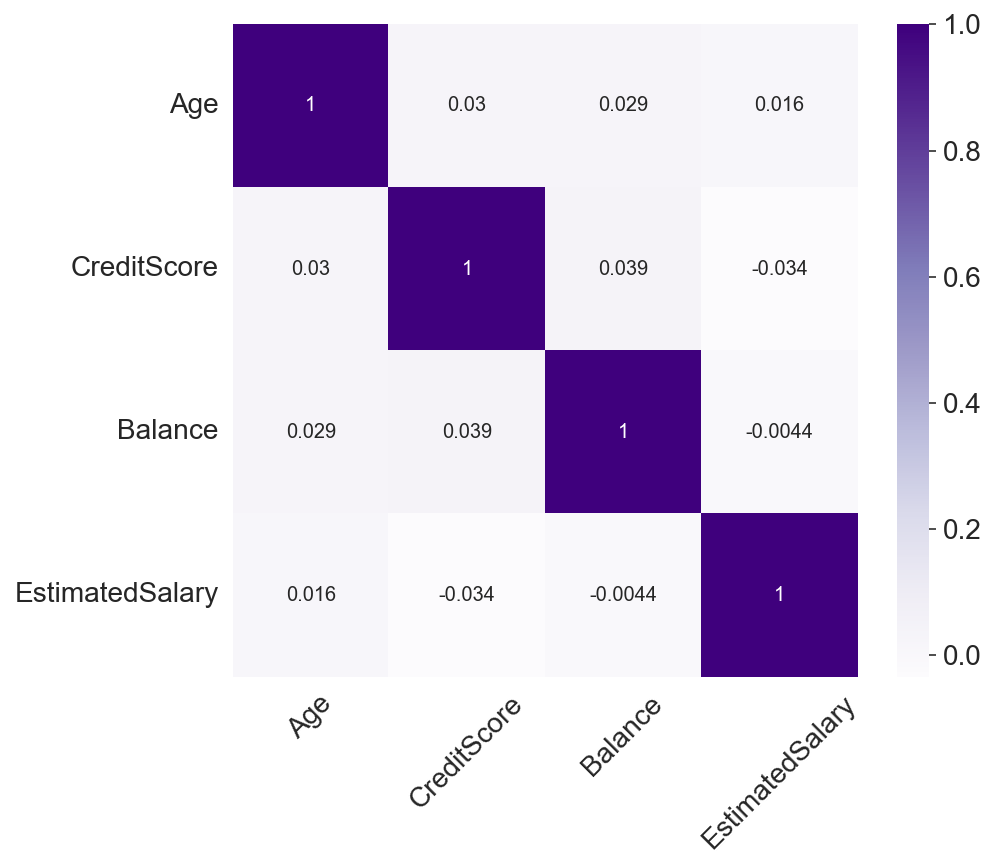

In [72]:
#Correlation between continuos variables 
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(train_df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 10},
            cmap='Purples',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

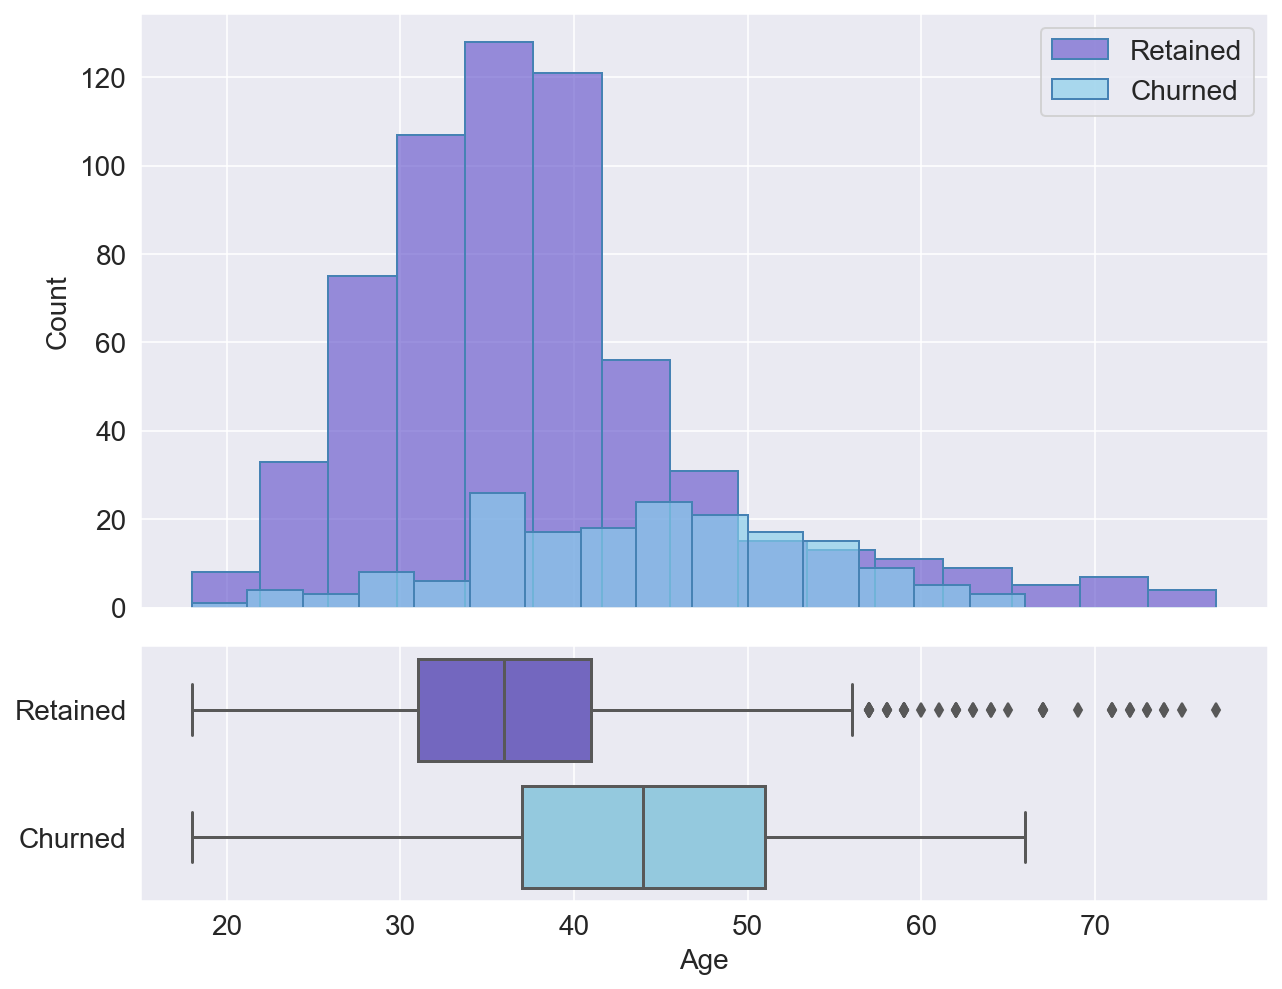

In [73]:
df_churned = train_df[train_df['Exited'] == 1]
df_retained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

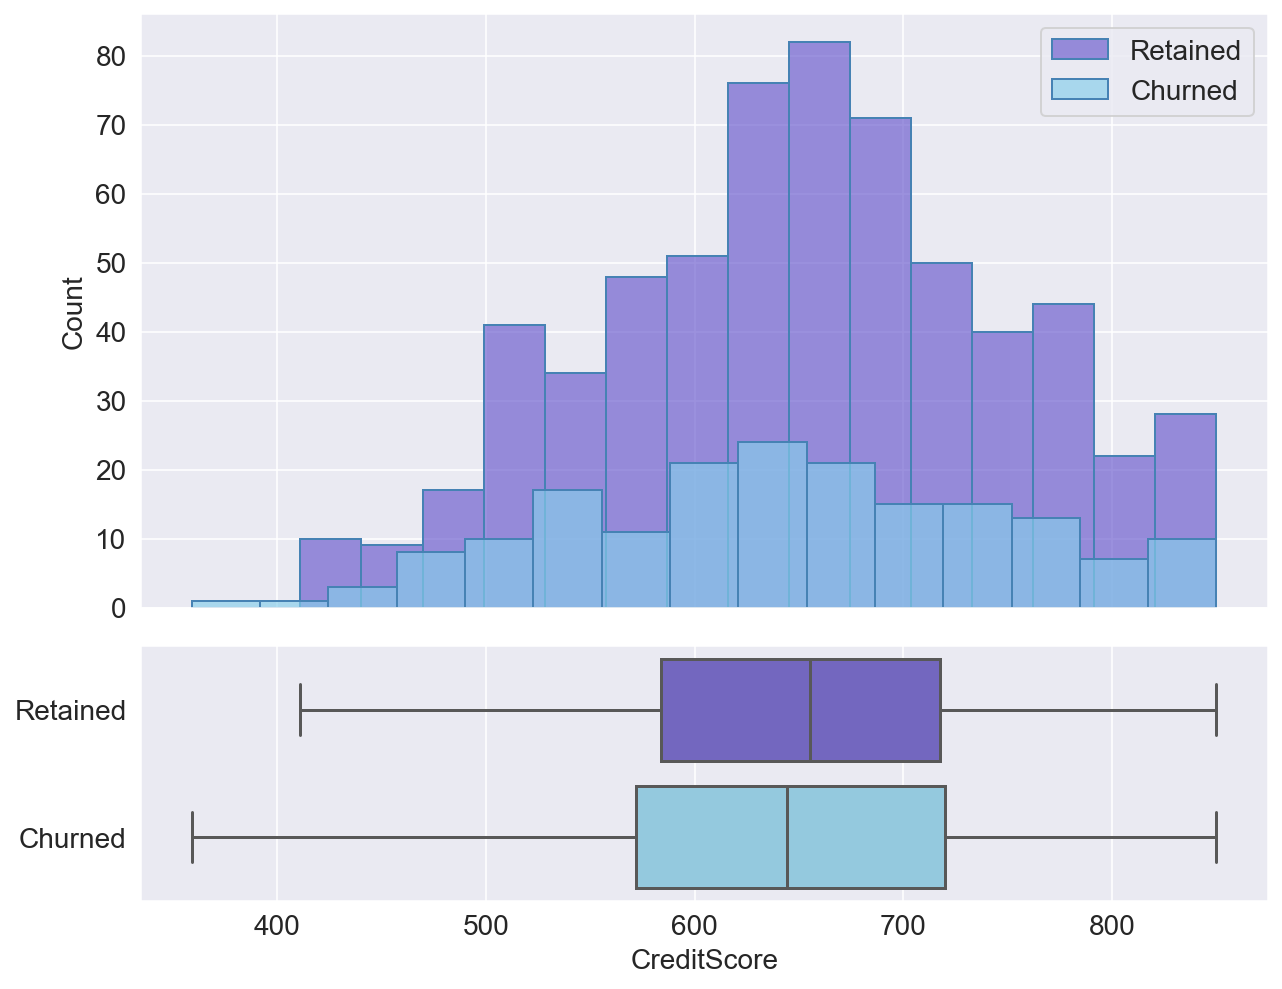

In [74]:
plot_continuous('CreditScore')

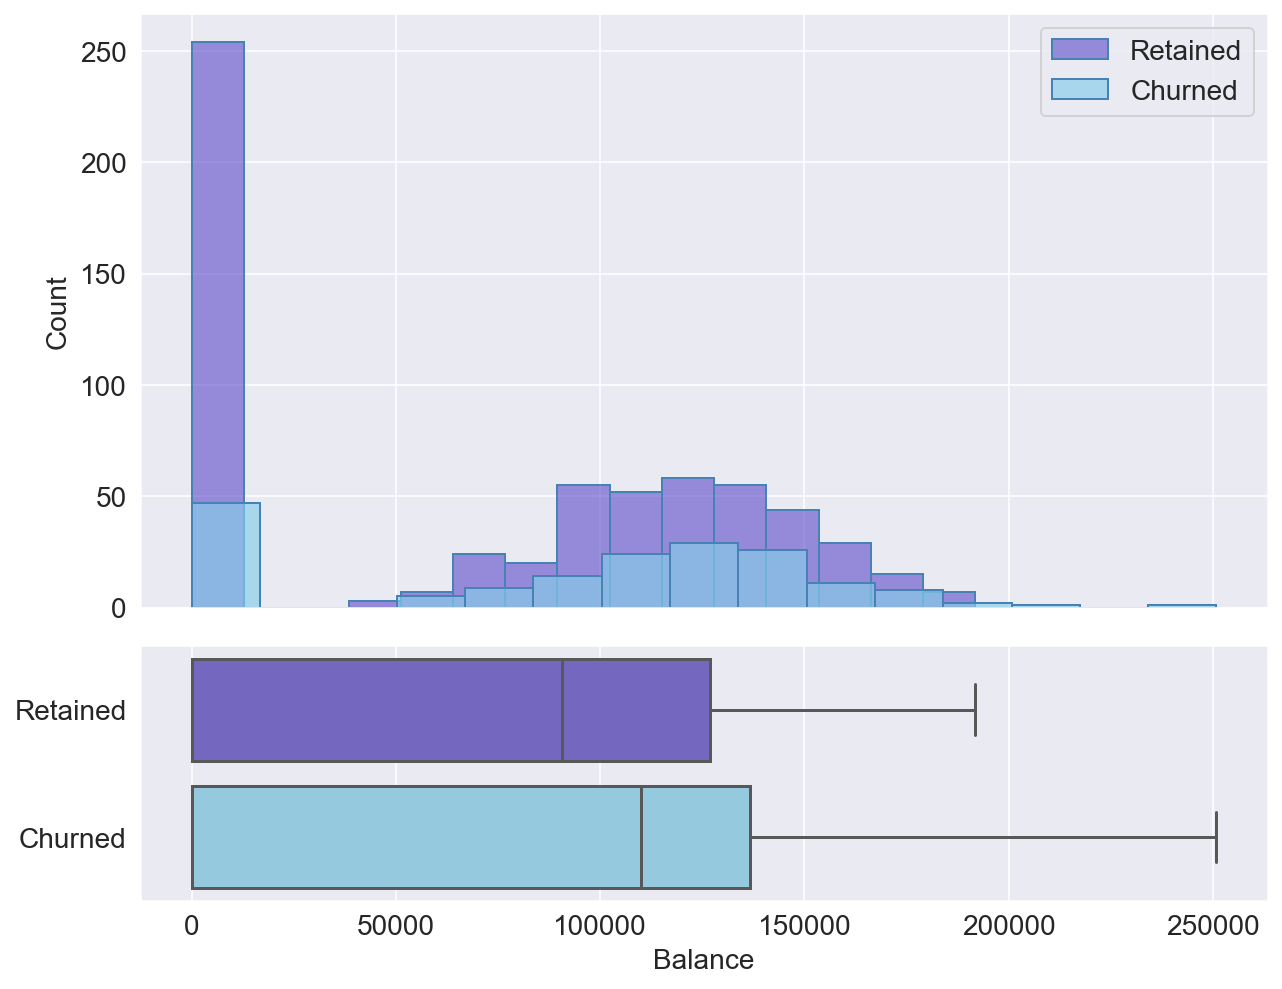

In [75]:
plot_continuous('Balance')

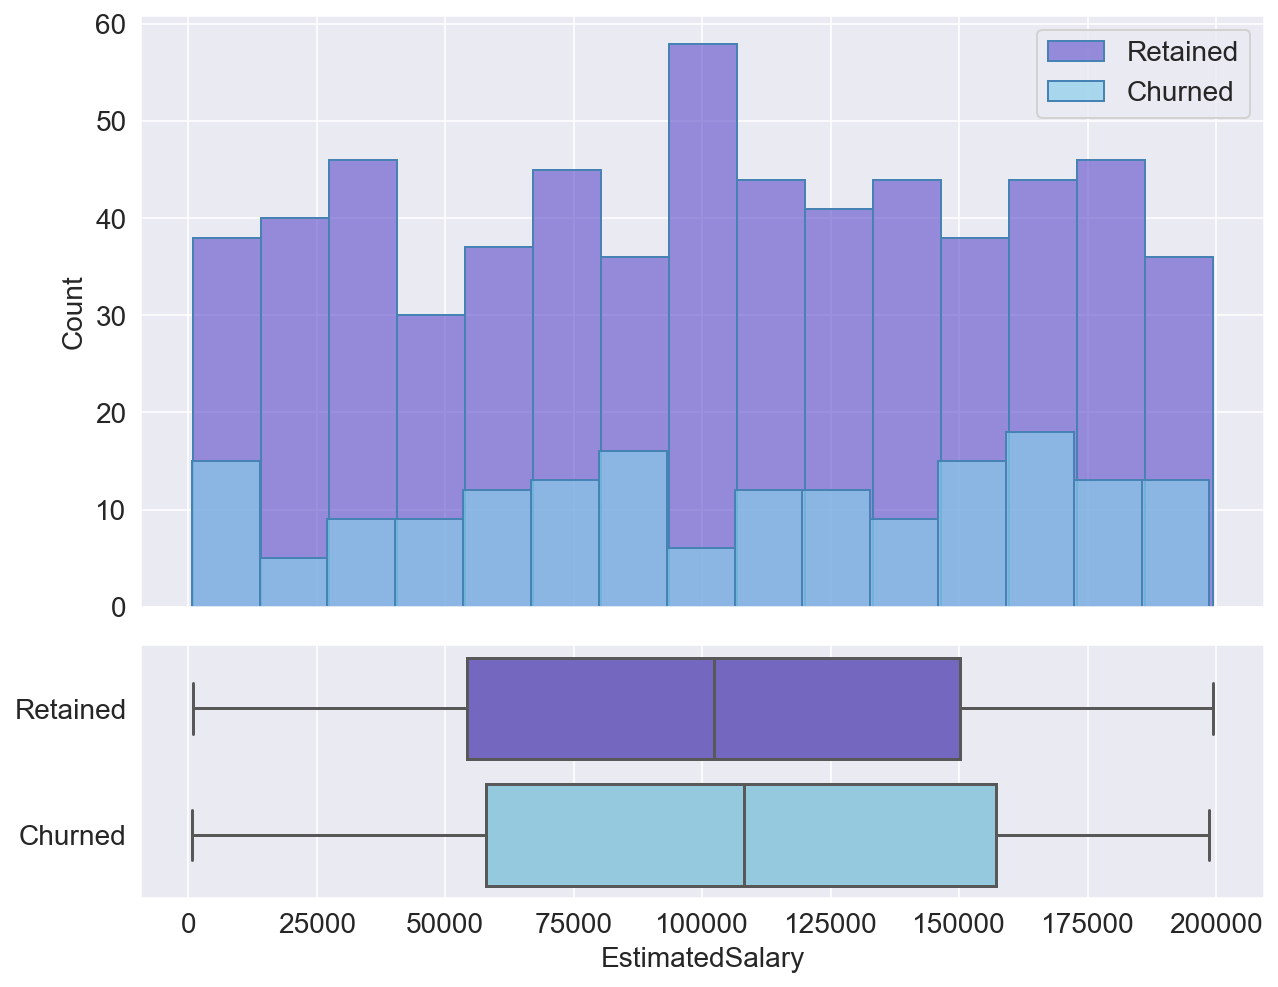

In [76]:
plot_continuous('EstimatedSalary')

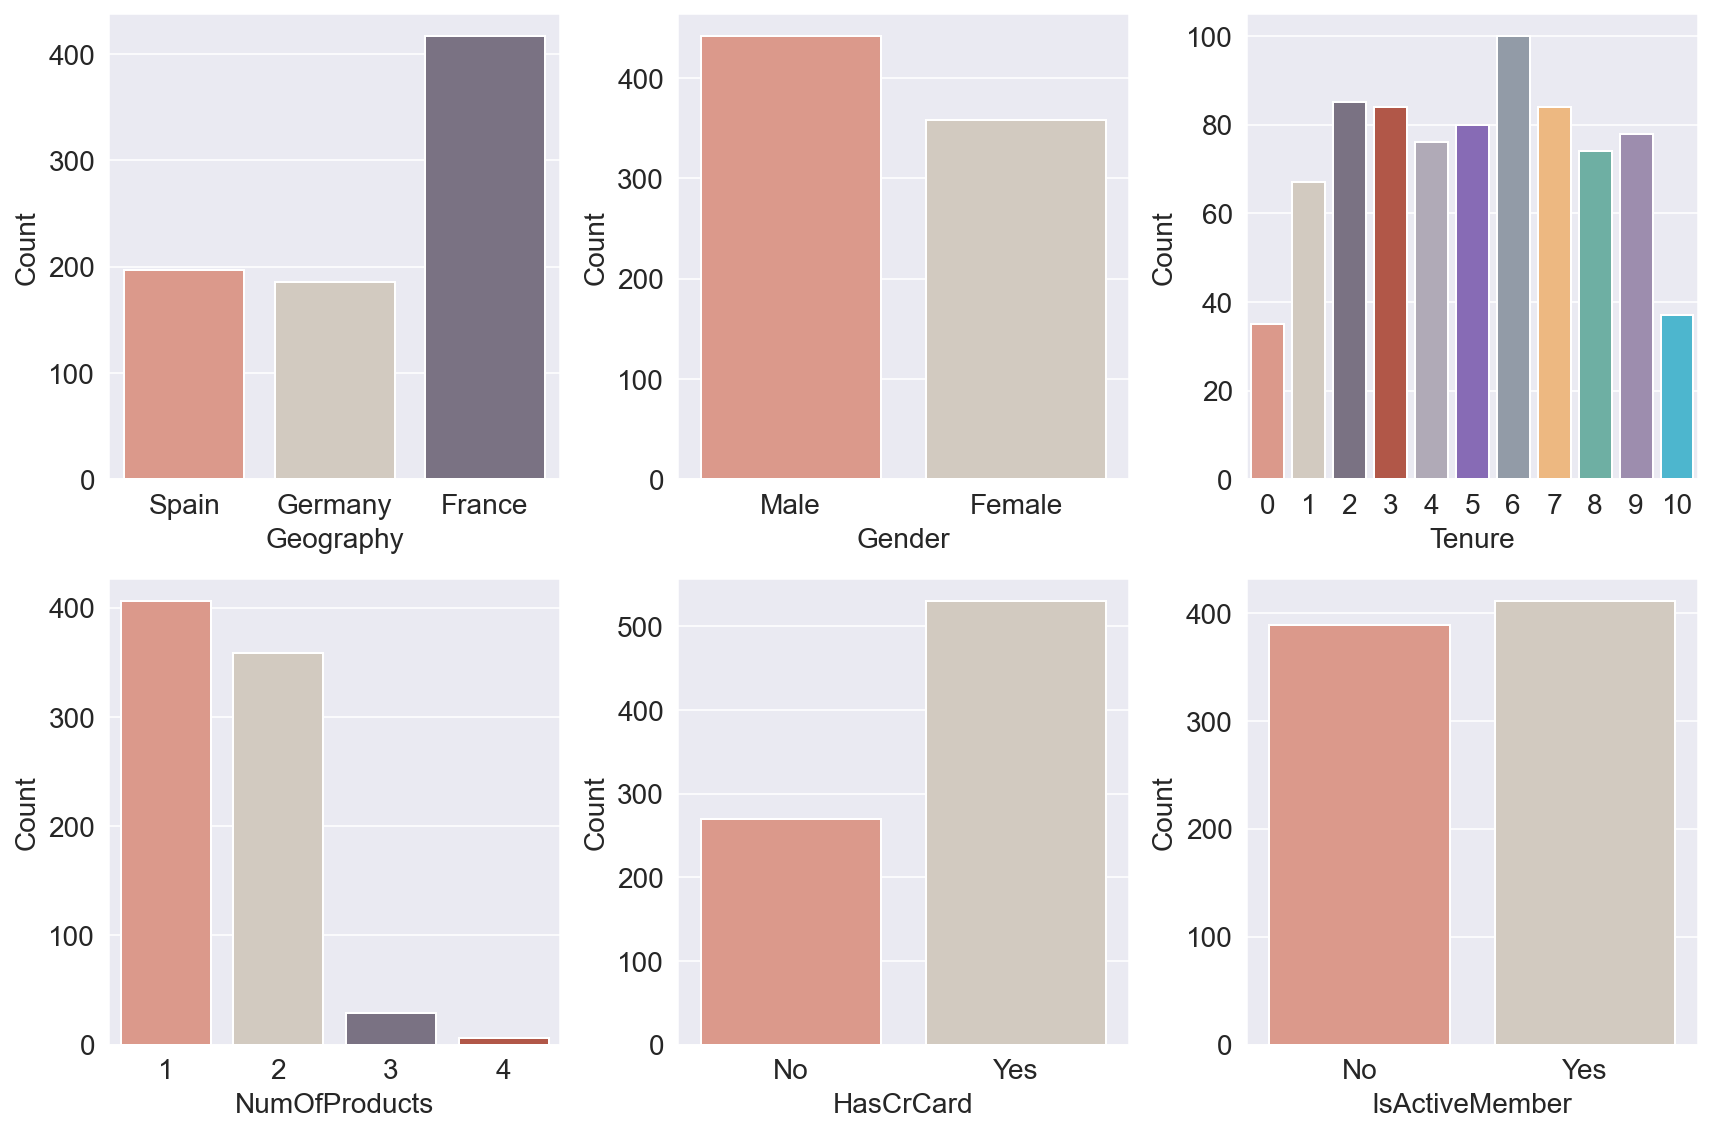

In [77]:
df_cat = train_df[categorical]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=train_df, palette=colors_cat)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

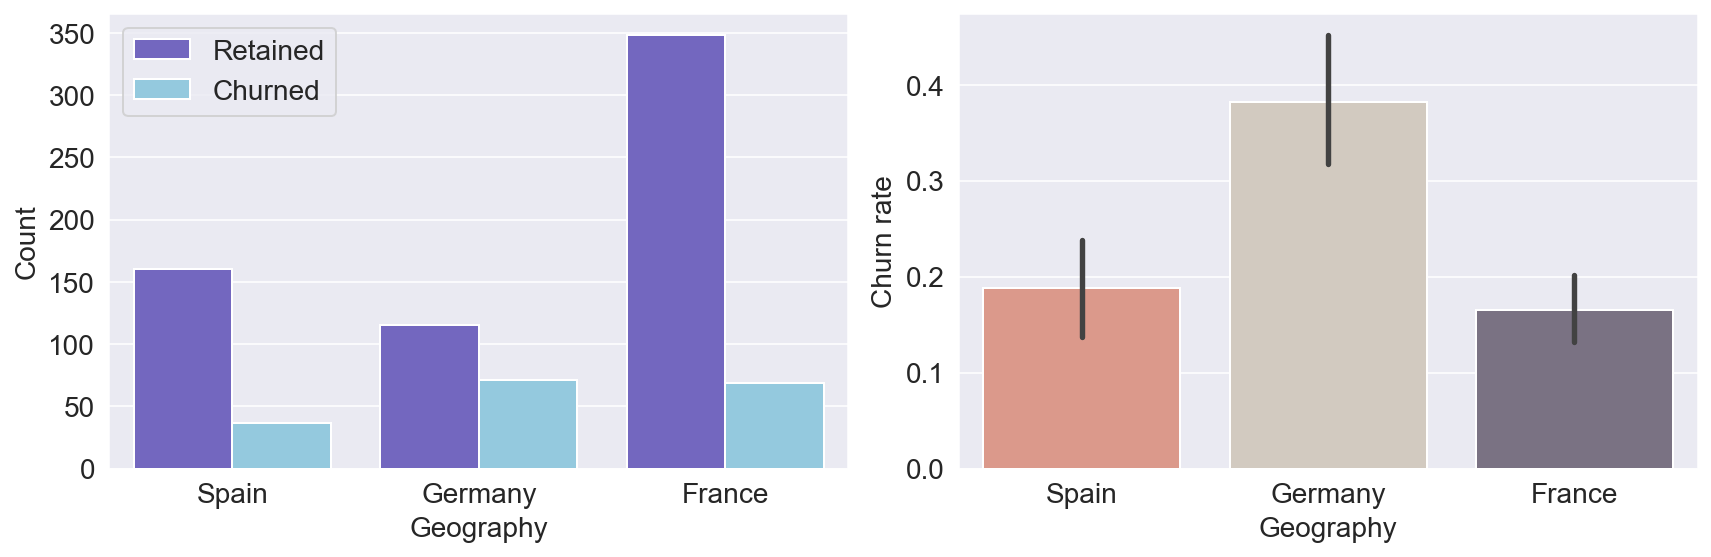

In [78]:
plot_categorical('Geography')

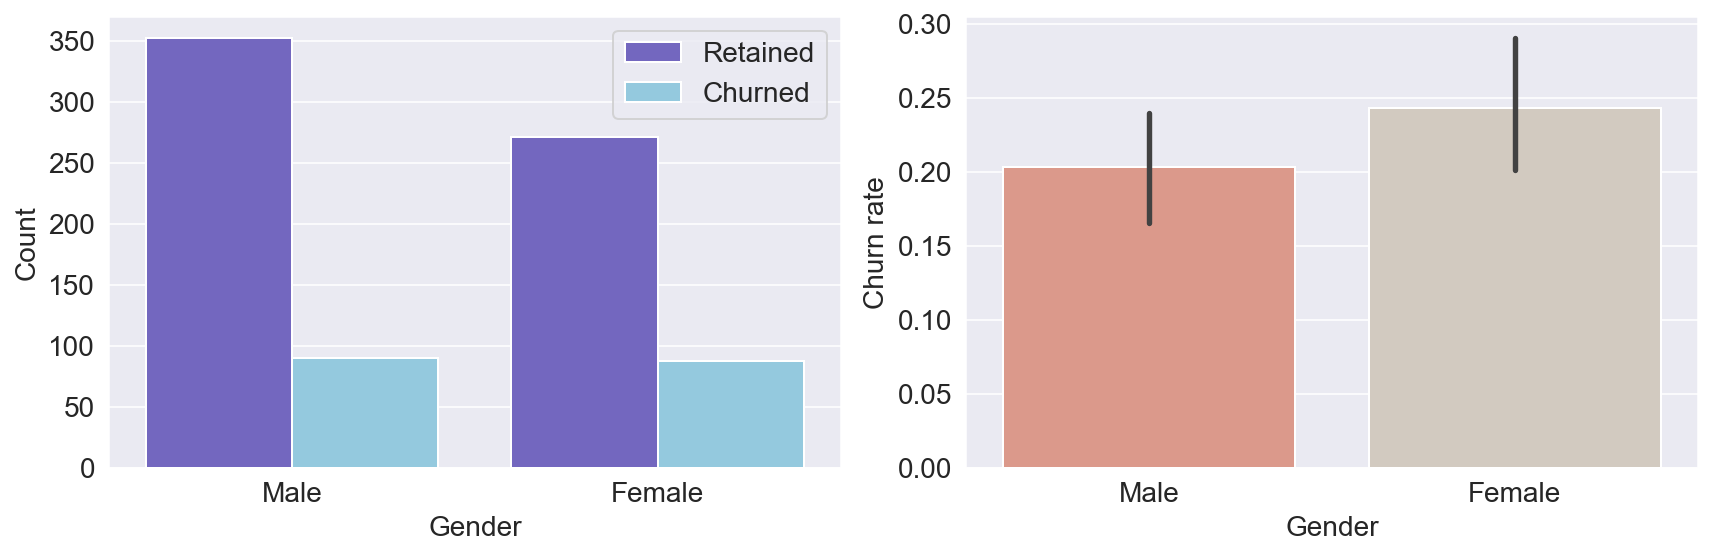

In [79]:
plot_categorical('Gender')

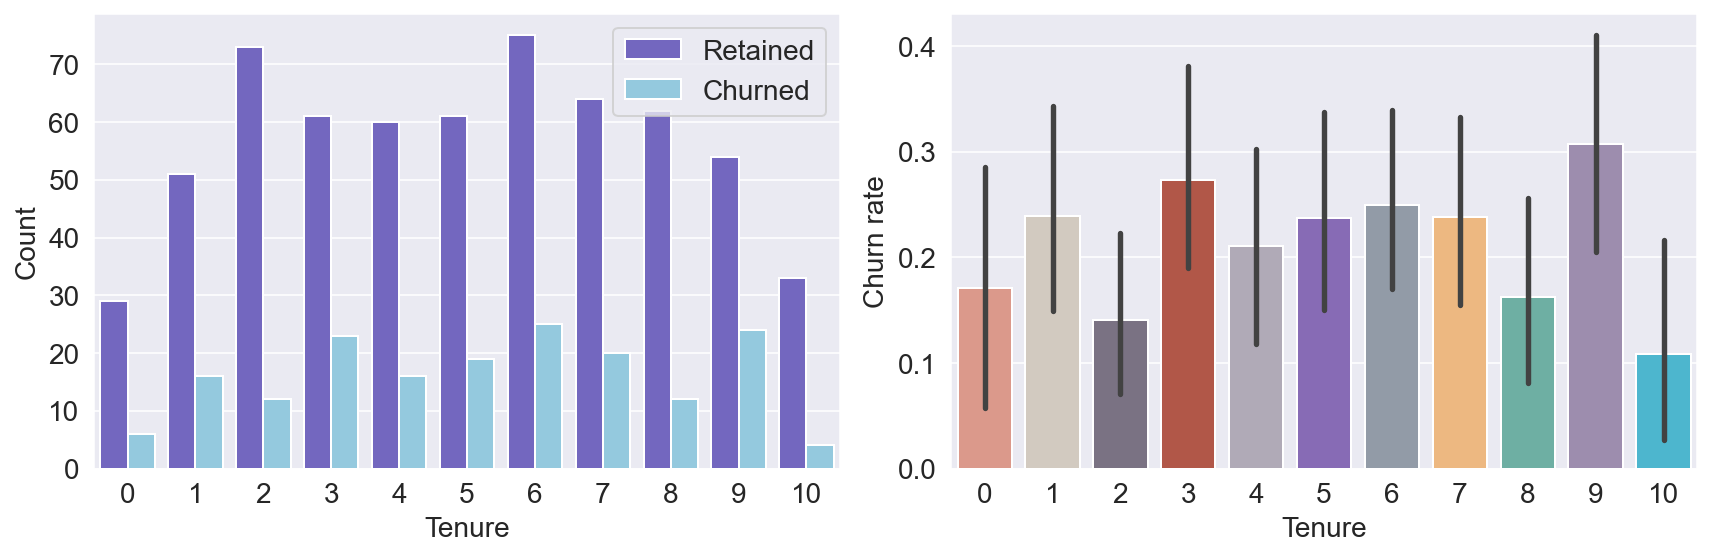

In [80]:
plot_categorical('Tenure')

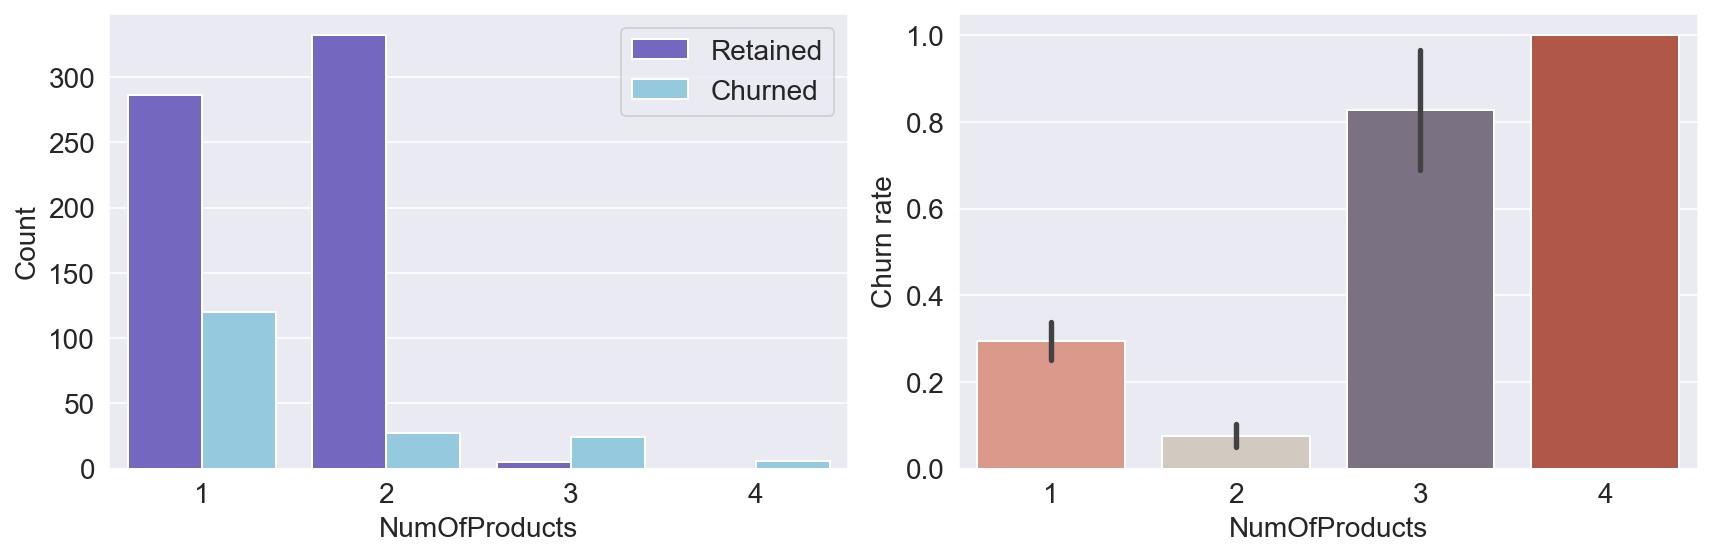

In [81]:
plot_categorical('NumOfProducts')

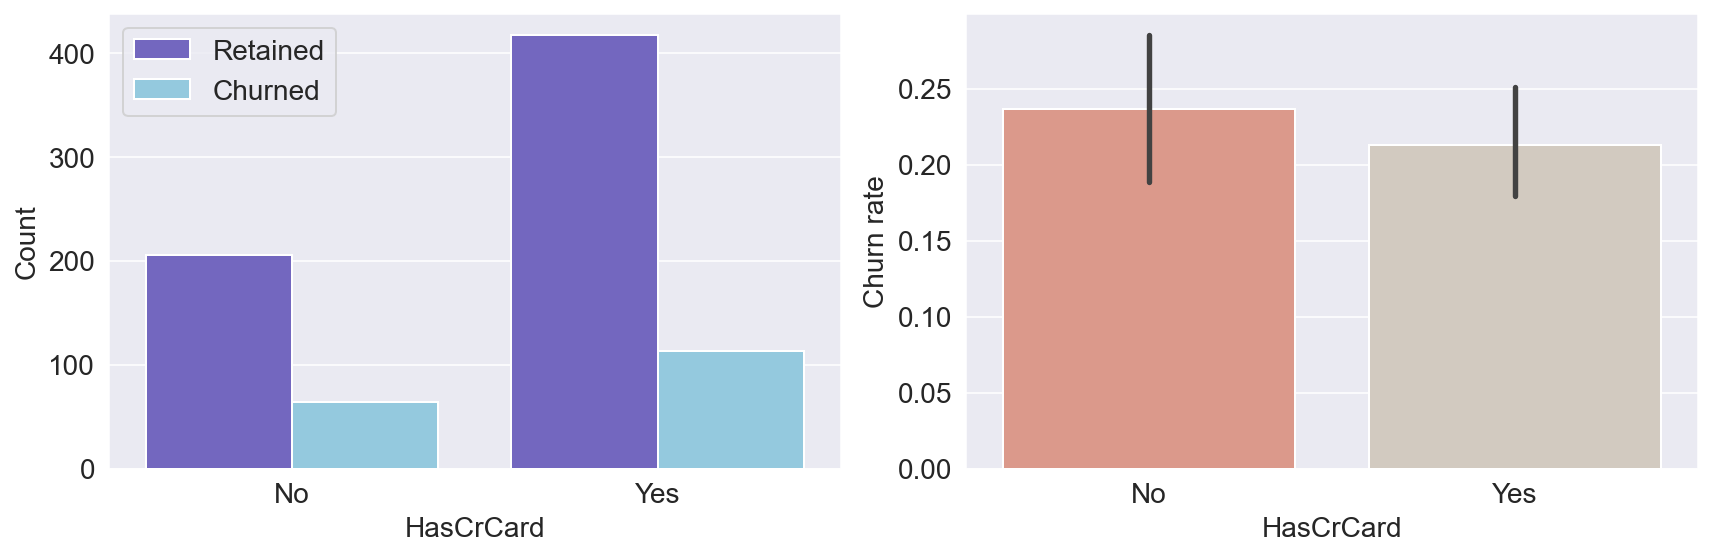

In [82]:
plot_categorical('HasCrCard')

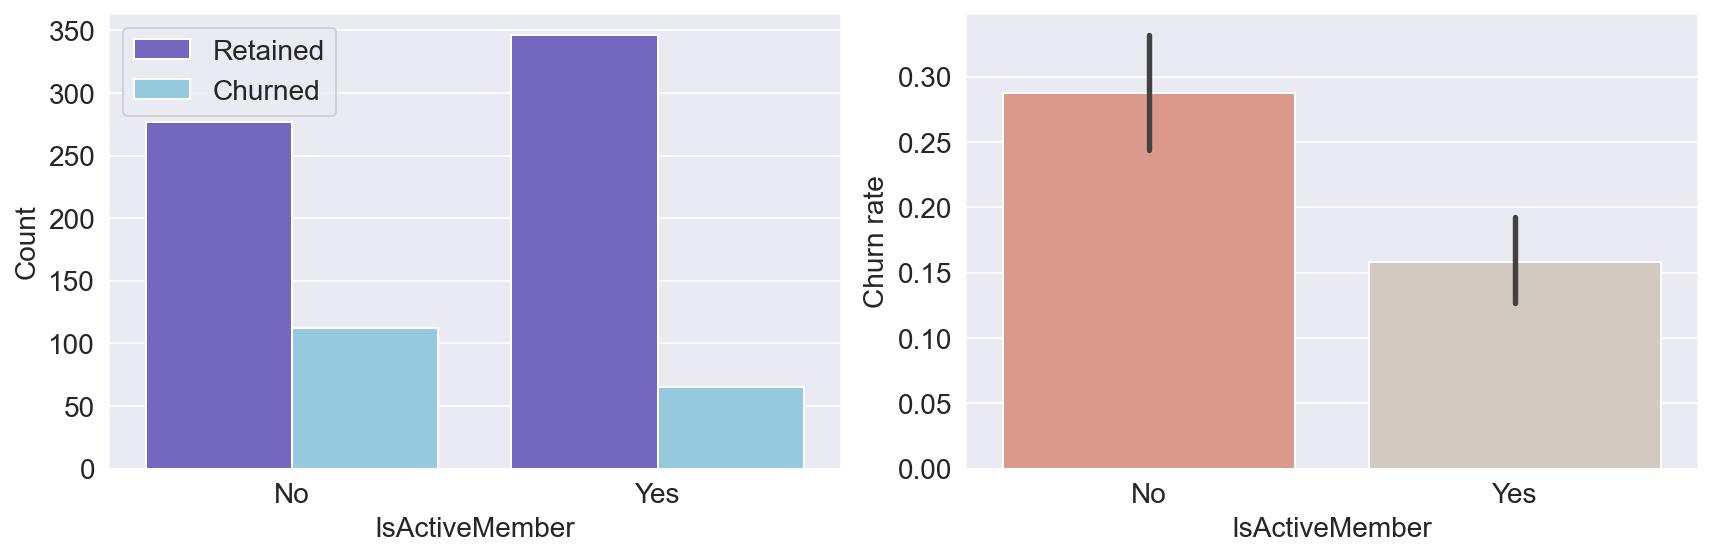

In [83]:
plot_categorical('IsActiveMember')

In [84]:
#Data Prep: eliminate features with little predictive value 

features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df = train_df.drop(features_drop, axis=1)

print('Features Dropped!')

Features Dropped!


In [85]:
#encoding Geo and Gender variables 

train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

print(' Features Encoded!')

 Features Encoded!


In [86]:
#scaling for class imbalance 
scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

print('Features Scaled!')

Features Scaled!


In [87]:
#creating train set 
y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

print(' Sets Created!')

 Sets Created!


In [88]:
y_train.value_counts()

0    623
1    177
Name: Exited, dtype: int64

In [89]:
#solving for class imbalance in the train set

over = SMOTE(sampling_strategy='auto', random_state=random_state)
X_train, y_train = over.fit_resample(X_train, y_train)

y_train.value_counts()

0    623
1    623
Name: Exited, dtype: int64


 Logistic Regression
-------------------------------
   Best Score (recall): 0.727
   Best Parameters: 
      C: 0.1
      max_iter: 100
      penalty: l2
      solver: lbfgs


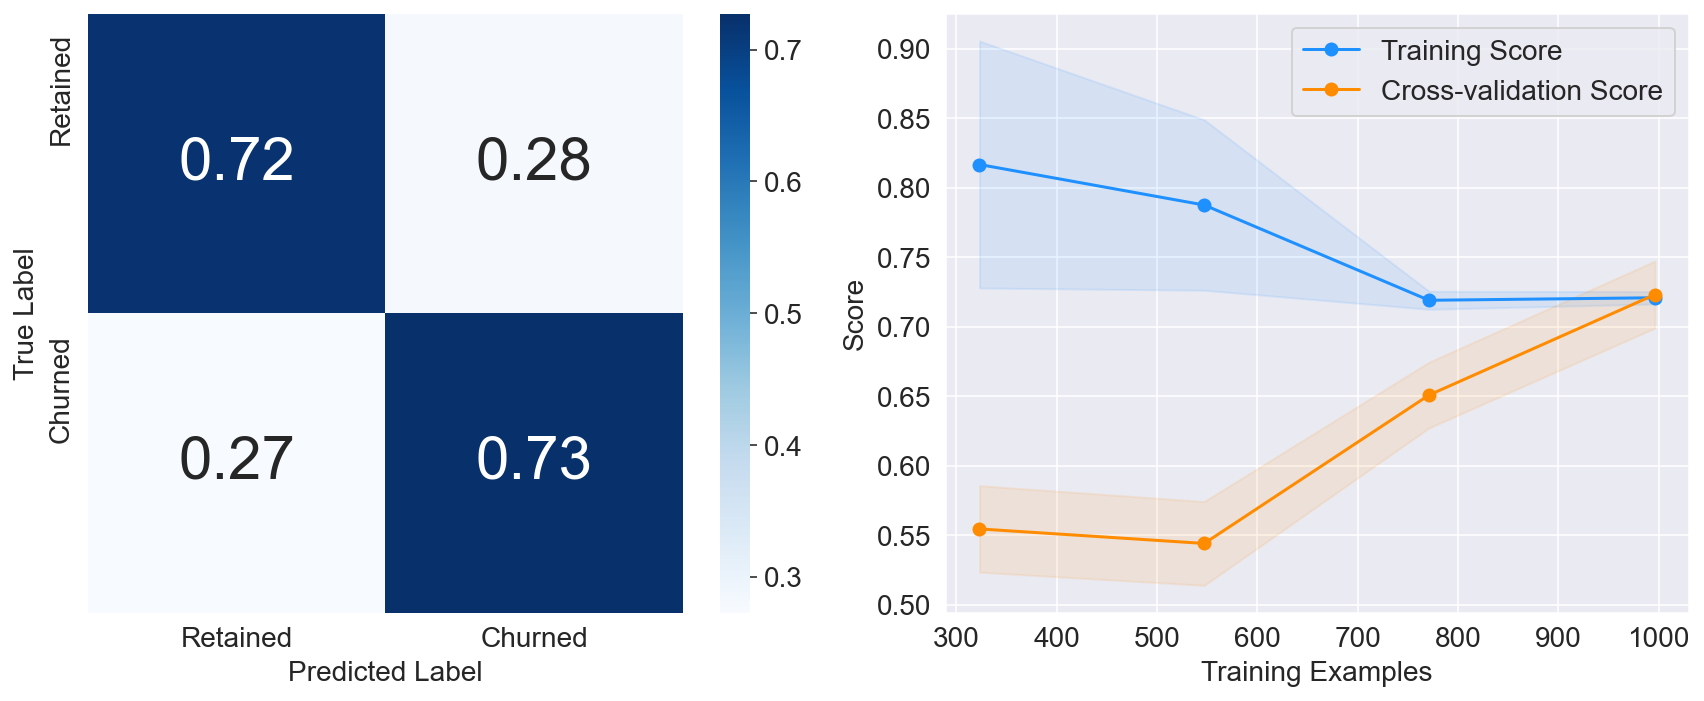

In [90]:
# First model: logistic regression : still deciding if I need the graphs

start=datetime.now()
lr = LogisticRegression(random_state=random_state)

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')
end=datetime.now()

In [91]:
#Interpretbility for LR

start=datetime.now()
lr2 = LogisticRegression(random_state=random_state)

lr_clf2 = lr2.fit(X_train, y_train)
    
#clf_performance(lr_clf2, 'Logistic Regression', 'LR')

importance = lr_clf2.coef_[0]
feat_importances = pd.Series(importance, index=X_train.columns)

print(feat_importances)

end=datetime.now()

CreditScore      -0.04
Geography         0.83
Gender           -0.50
Age               0.87
Balance           0.13
NumOfProducts    -0.14
IsActiveMember   -1.22
dtype: float64


In [92]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:00.006002



 Support Vector Classifier
-------------------------------
   Best Score (recall): 0.745
   Best Parameters: 
      C: 0.1
      kernel: linear


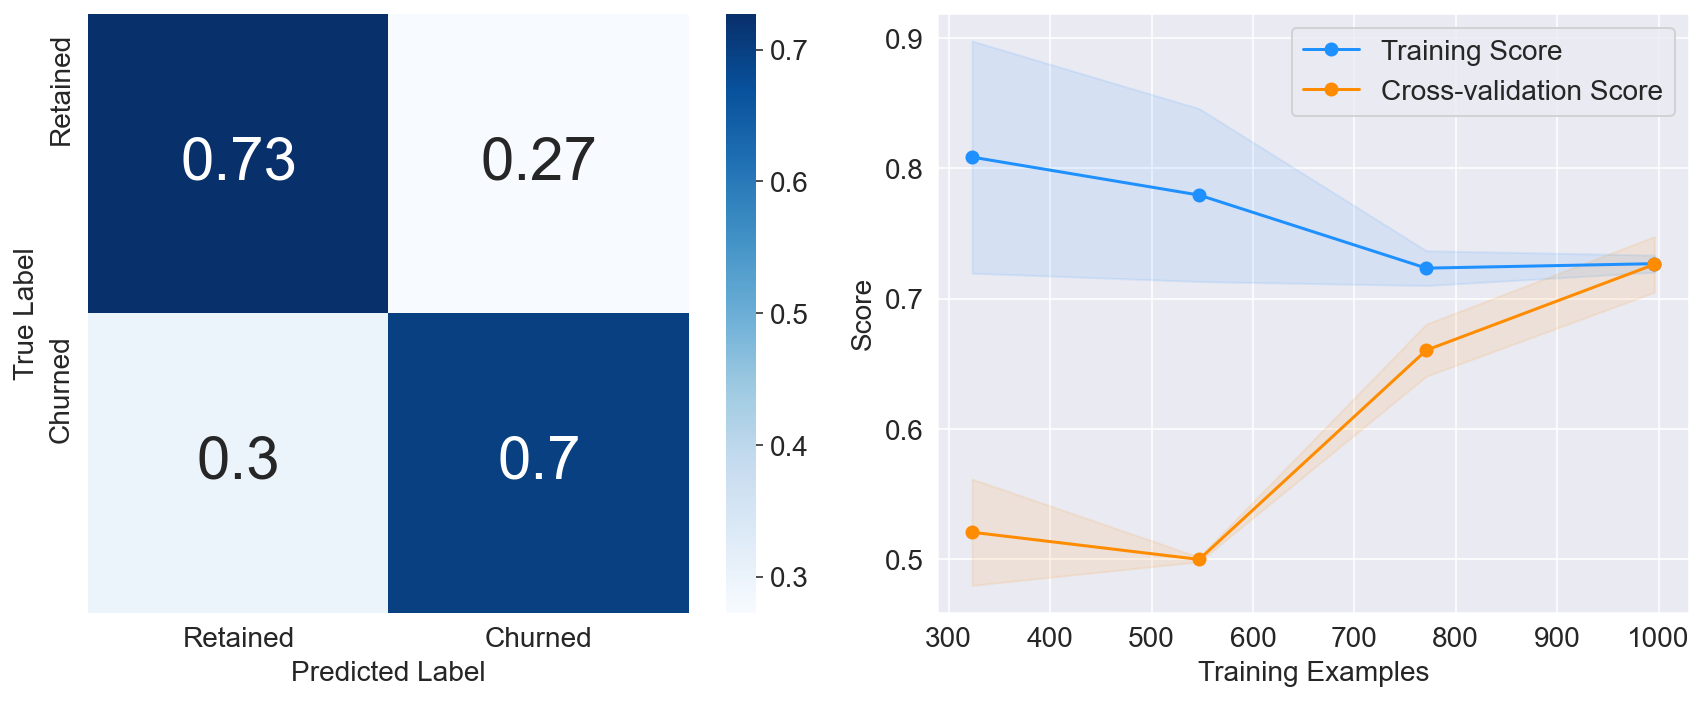

In [93]:
#second model: SVCM

start=datetime.now()

svc = SVC(probability=True, random_state=random_state)

param_grid = tuned_parameters = [
                                 {'kernel': ['linear'],
                                  'C': [.1, 1, 10]}
                                ]

svc_clf = GridSearchCV(estimator=svc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_svc_clf = svc_clf.fit(X_train, y_train)
clf_performance(best_svc_clf, 'Support Vector Classifier', 'SVC')
end=datetime.now()


In [94]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:01.493322


In [95]:
#interpretability for SVCM

start=datetime.now()
SVC2 = SVC(probability=True, random_state=random_state, kernel="linear")

SVC_clf2 = SVC2.fit(X_train, y_train)
    
importance = SVC_clf2.coef_[0]
feat_importances = pd.Series(importance, index=X_train.columns)

print(feat_importances)

end=datetime.now()

CreditScore      -0.07
Geography         0.95
Gender           -0.52
Age               0.87
Balance           0.03
NumOfProducts    -0.14
IsActiveMember   -0.94
dtype: float64


In [96]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:00.188042



 Random Forest
-------------------------------
   Best Score (recall): 0.835
   Best Parameters: 
      bootstrap: True
      criterion: gini
      max_depth: 6
      max_features: auto
      min_samples_leaf: 2
      min_samples_split: 5
      n_estimators: 100


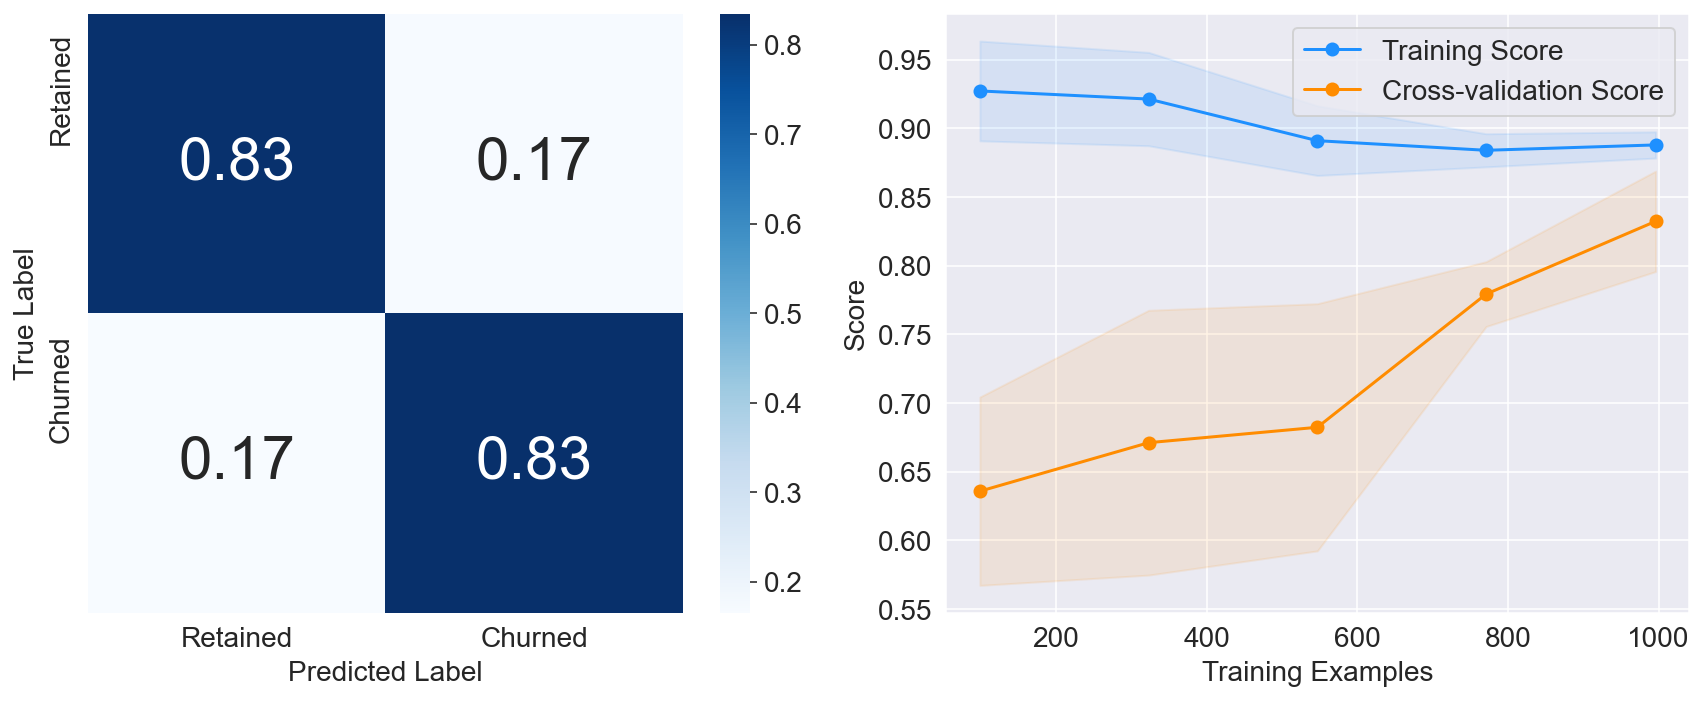

In [97]:
#RF model fit 

start=datetime.now()

rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

end=datetime.now()

In [98]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:06.625503



 Gradient Boosting Classifier
-------------------------------
   Best Score (recall): 0.827
   Best Parameters: 
      learning_rate: 0.01
      max_depth: 3
      max_features: log2
      min_samples_leaf: 5
      min_samples_split: 5
      n_estimators: 600
      n_iter_no_change: 20
      subsample: 0.66
      tol: 0.01
      validation_fraction: 0.2


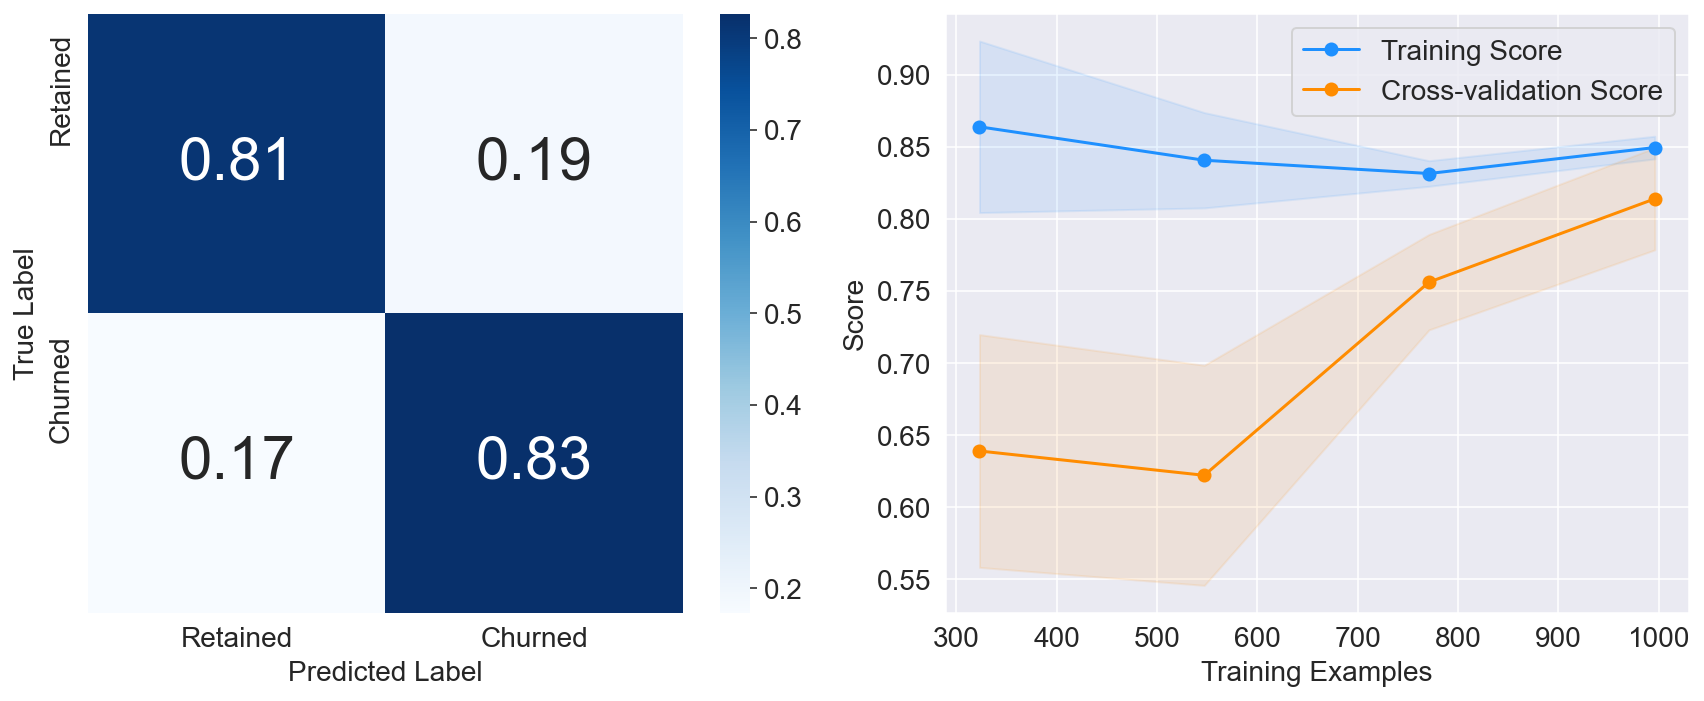

In [99]:
#GBMC model fit

start=datetime.now()

gbc = GradientBoostingClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [600],
    'subsample': [0.66, 0.75],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3],  
    'min_samples_split': [5, 7],
    'min_samples_leaf': [3, 5],
    'max_features': ['auto', 'log2', None],
    'n_iter_no_change': [20],
    'validation_fraction': [0.2],
    'tol': [0.01]
}

gbc_clf = GridSearchCV(estimator=gbc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_gbc_clf = gbc_clf.fit(X_train, y_train)
clf_performance(best_gbc_clf, 'Gradient Boosting Classifier', 'GBC')

end=datetime.now()

In [100]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:06.590472


[18:34:00] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.832
   Best Parameters: 
      colsample_bytree: 0.5
      gamma: 0.1
      learning_rate: 0.01
      max_depth: 4
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 1
      reg_lambda: 1
      subsample: 0.75
[18:34:00] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:34:00] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the defaul

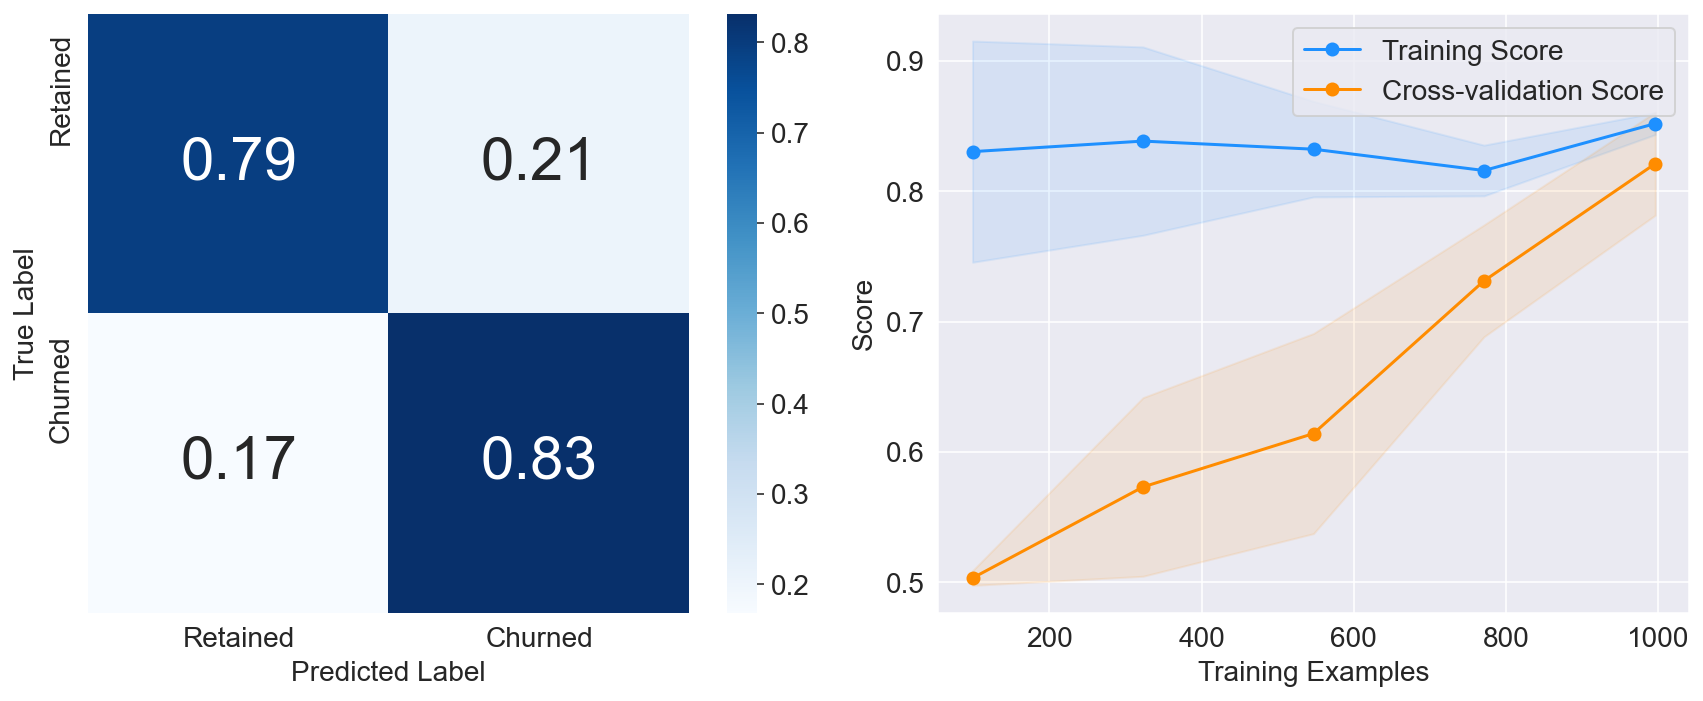

In [101]:
#XGBMC fit

start=datetime.now()
xgb = XGBClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 4],  
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=xgb,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')
end=datetime.now()

In [102]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:23.051146


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5

 LGBMClassifier
-------------------------------
   Best Score (recall): 0.824
   Best Parameters: 
      feature_fraction: 0.5
      learning_rate: 0.01
      max_depth: 5
      min_child_samples: 10
      n_estimators: 200
      num_leaves: 10
      reg_alpha: 0.1
      reg_lambda: 0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


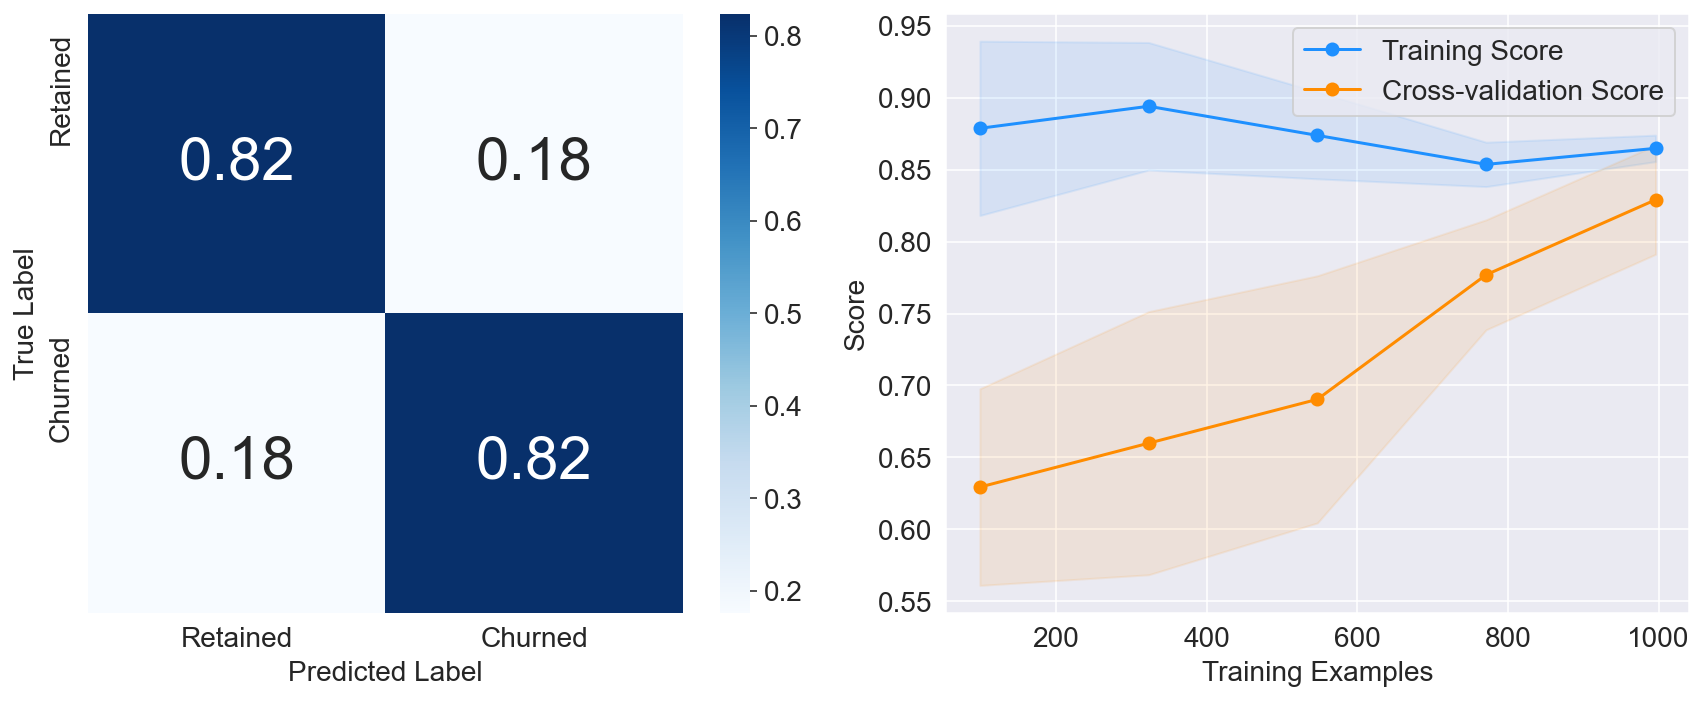

In [103]:
#LGBMC fit
start=datetime.now()

lgbmc = LGBMClassifier(random_state=random_state)

param_grid = {
    'max_depth': [5],
    'num_leaves': [5, 10],
    'learning_rate': [0.001, 0.01],
    'n_estimators': [200],
    'feature_fraction': [0.5],
    'min_child_samples': [5, 10],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

lgbmc_clf = GridSearchCV(estimator=lgbmc,
                         param_grid=param_grid,
                         scoring=scoring_metric,
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

best_lgbmc_clf = lgbmc_clf.fit(X_train, y_train)
clf_performance(best_lgbmc_clf, 'LGBMClassifier', 'LGBMC')

end=datetime.now()

In [104]:
print("time to fit model in train set:",end-start)

time to fit model in train set: 0:00:10.035240


Soft Voting
-----------------
  Recall:  0.841


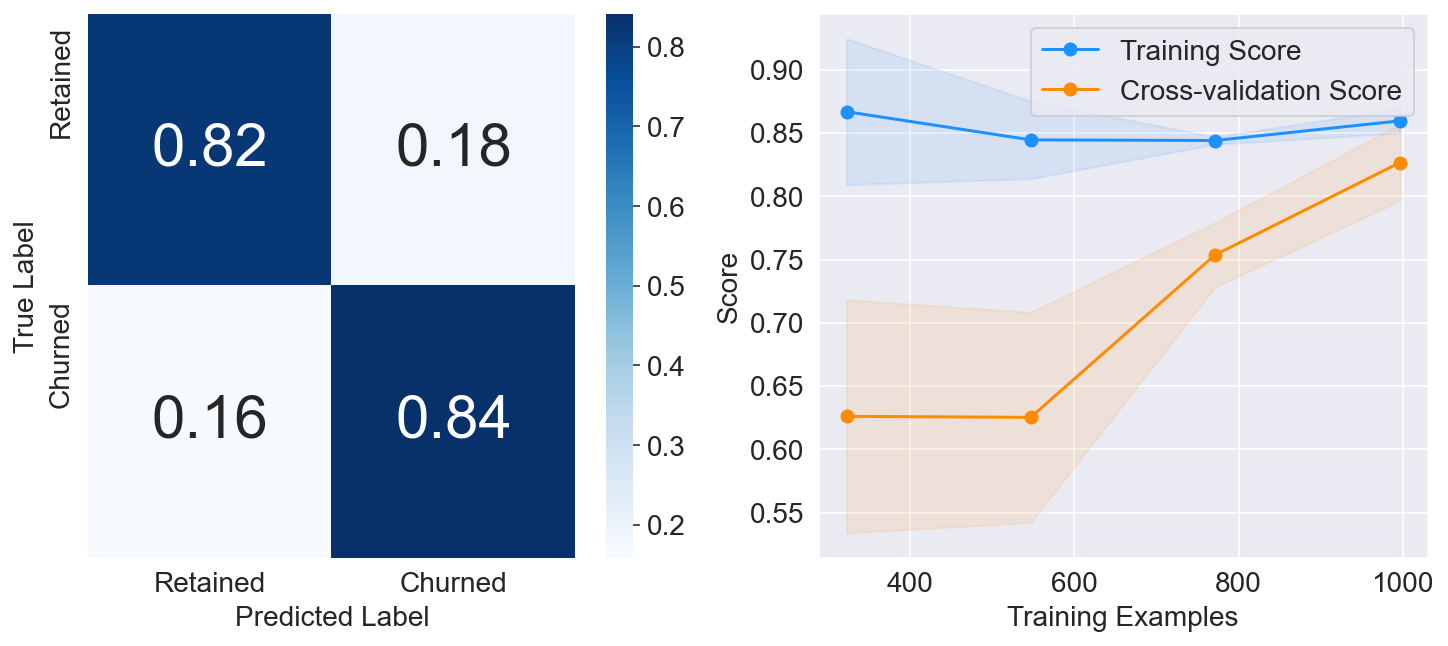

In [105]:
#softvoting for better model fit

estimators = [('LR', best_lr_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('GBC', best_gbc_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_),
              ('LGBMC', best_lgbmc_clf.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators=estimators[1:],
                                     voting='soft',
                                     n_jobs=-1)
estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft,
                              X_train,
                              y_train,
                              cv=5,
                              method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize='true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [
    accuracy_score(y_train, y_pred),
    precision_score(y_train, y_pred),
    recall_score(y_train, y_pred),
    roc_auc_score(y_train, y_pred_pp), fpr, tpr
]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_conf_mx(cm, ax1)
plot_learning_curve(tuned_voting_soft, X_train, y_train, ax2)

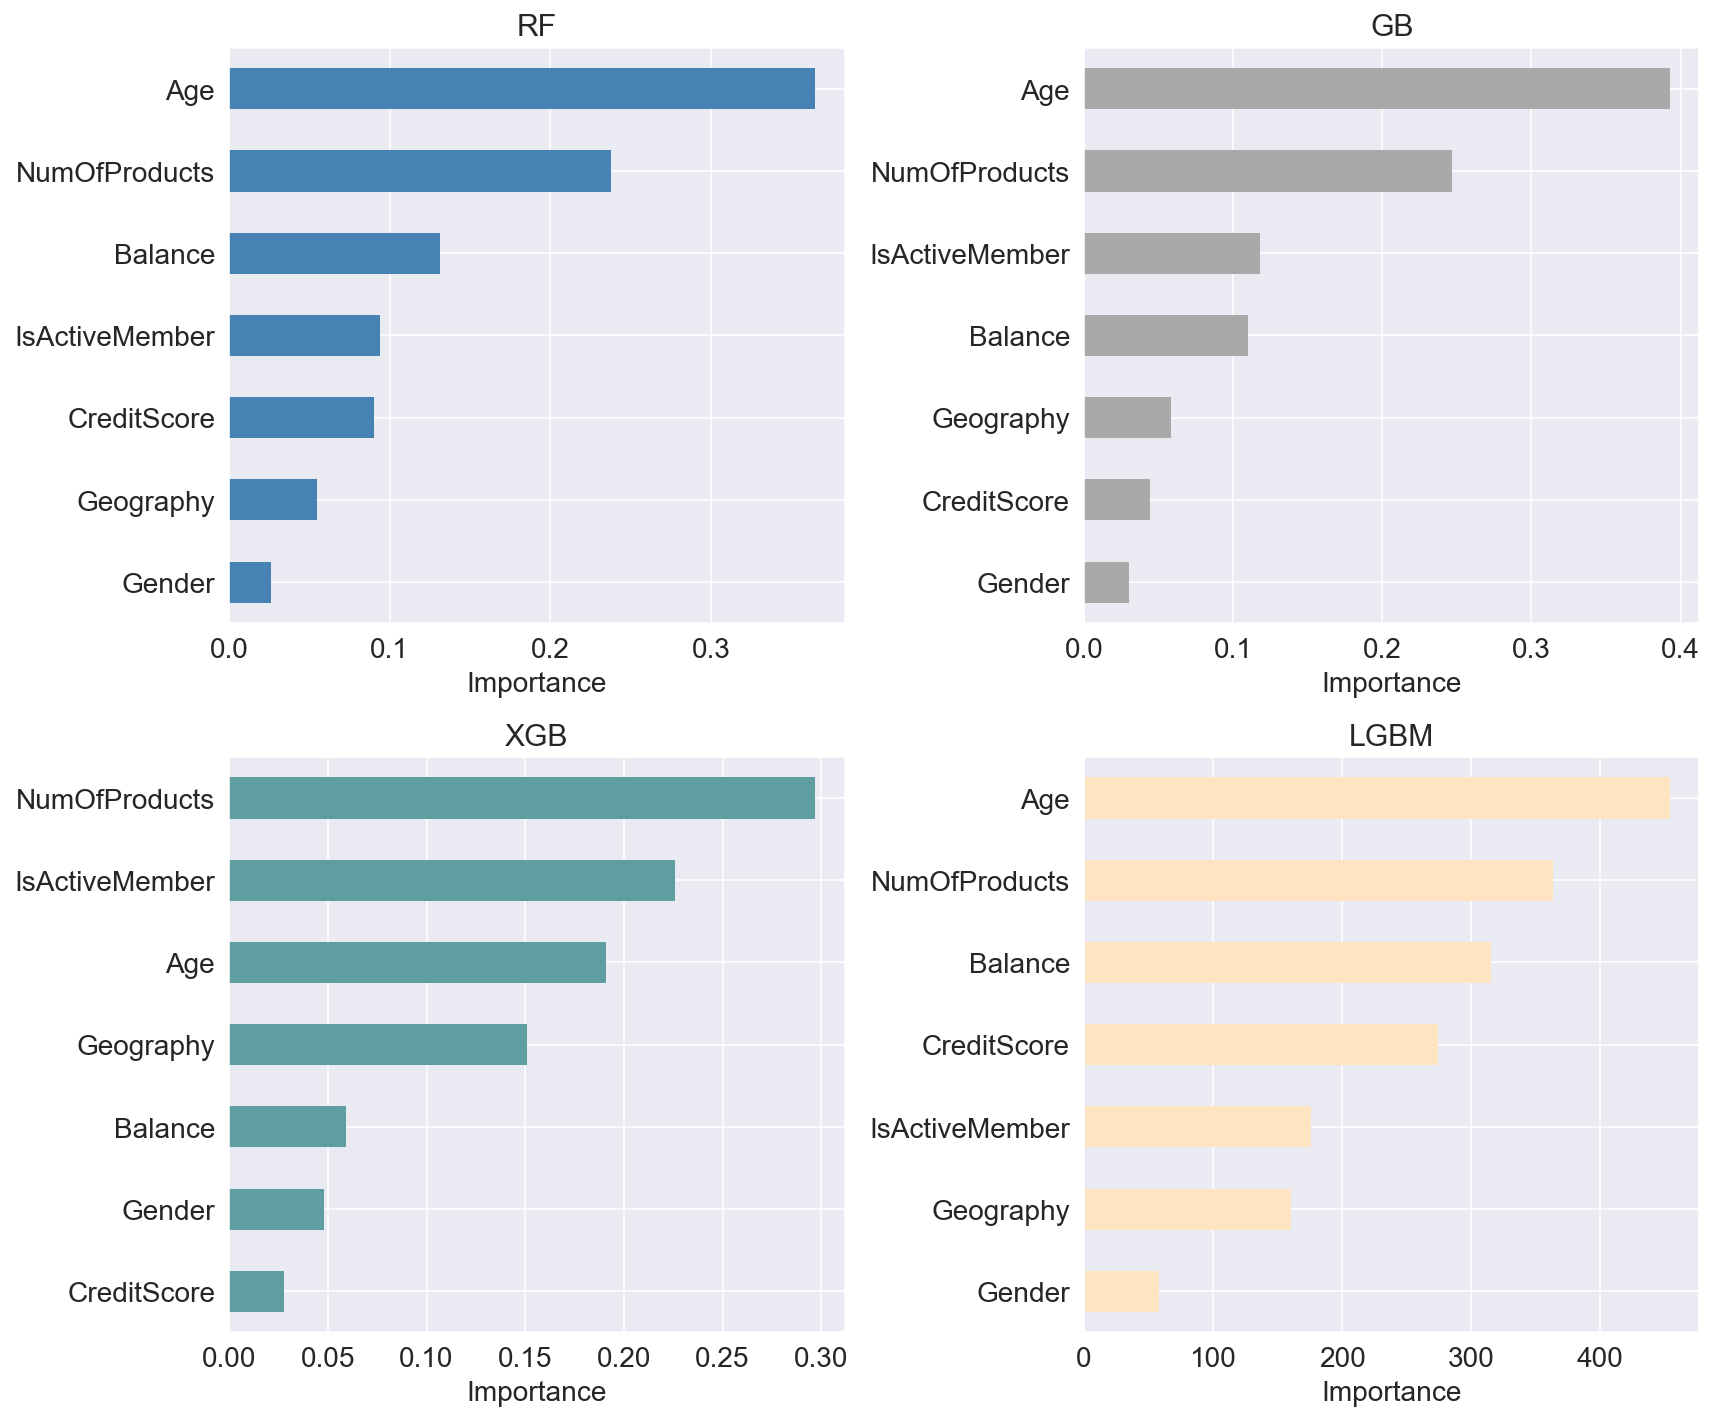

In [106]:

#Feature importance     
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig = plt.subplots(2, 2, figsize=(12, 10))

for i, (name, clf) in enumerate(zip(['RF', 'GB', 'XGB', 'LGBM'],
                                    [best_rf_clf, best_gbc_clf, best_xgb_clf, best_lgbmc_clf])):

    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, colors_fi[i], ax)
    plt.ylabel('')

plt.tight_layout();

In [107]:
#Feature importance for Random Forest 
importances2 = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(best_rf_clf.best_estimator_.feature_importances_, 3)})

importances2 = importances2.sort_values('Importance', ascending=True).set_index('Feature')

print(importances2)

                Importance
Feature                   
Gender                0.03
Geography             0.06
CreditScore           0.09
IsActiveMember        0.09
Balance               0.13
NumOfProducts         0.24
Age                   0.36


In [108]:
#Feature importance for GBMC

importances2 = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(best_gbc_clf.best_estimator_.feature_importances_, 4)})

importances2 = importances2.sort_values('Importance', ascending=True).set_index('Feature')

print(importances2)

                Importance
Feature                   
Gender                0.03
CreditScore           0.04
Geography             0.06
Balance               0.11
IsActiveMember        0.12
NumOfProducts         0.25
Age                   0.39


In [109]:
#Feature importance for XGBMC
importances2 = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(best_xgb_clf.best_estimator_.feature_importances_, 4)})

importances2 = importances2.sort_values('Importance', ascending=True).set_index('Feature')

print(importances2)

                Importance
Feature                   
CreditScore           0.03
Gender                0.05
Balance               0.06
Geography             0.15
Age                   0.19
IsActiveMember        0.23
NumOfProducts         0.30


In [110]:
#Feature importance for LGBMC
importances2 = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(best_lgbmc_clf.best_estimator_.feature_importances_, 4)})

importances2 = importances2.sort_values('Importance', ascending=True).set_index('Feature')

print(importances2)

                Importance
Feature                   
Gender                  58
Geography              160
IsActiveMember         176
CreditScore            274
Balance                315
NumOfProducts          363
Age                    454


In [111]:
#Comparison across prediction metrics

comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

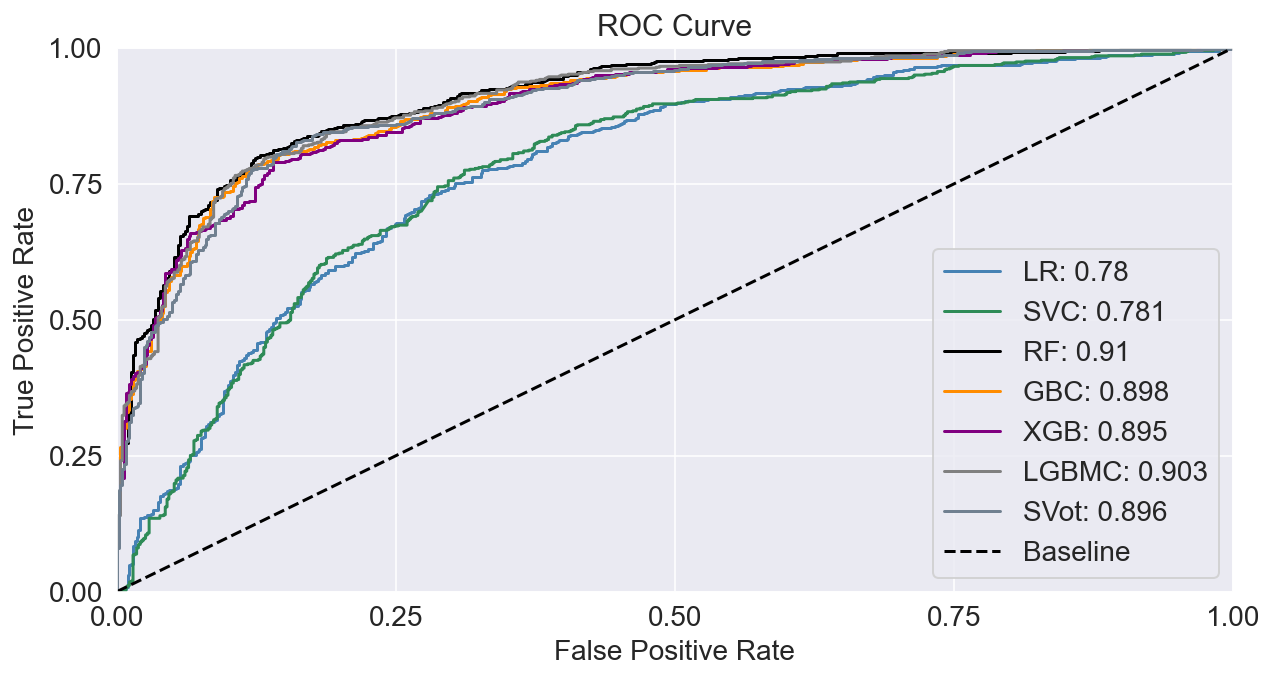

In [112]:
#Lets ROC'n'roll all night! 

fig, ax = plt.subplots(figsize=(10, 5))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    ax.plot(fpr,
            tpr,
            color=colors_comp[index],
            label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('True Positive Rate')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=14);

In [113]:
#Proof in the pudding, the test set 

test_df = test_df.drop(features_drop, axis=1)

test_df['Gender'] = LabelEncoder().fit_transform(test_df['Gender'])
test_df['Geography'] = test_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

test_df[scl_columns] = scaler.transform(test_df[scl_columns])  # not fit_transform, scaler has already been trained

y_test = test_df['Exited']
X_test = test_df.drop('Exited', 1)

print('Preprocessing Complete!')

Preprocessing Complete!


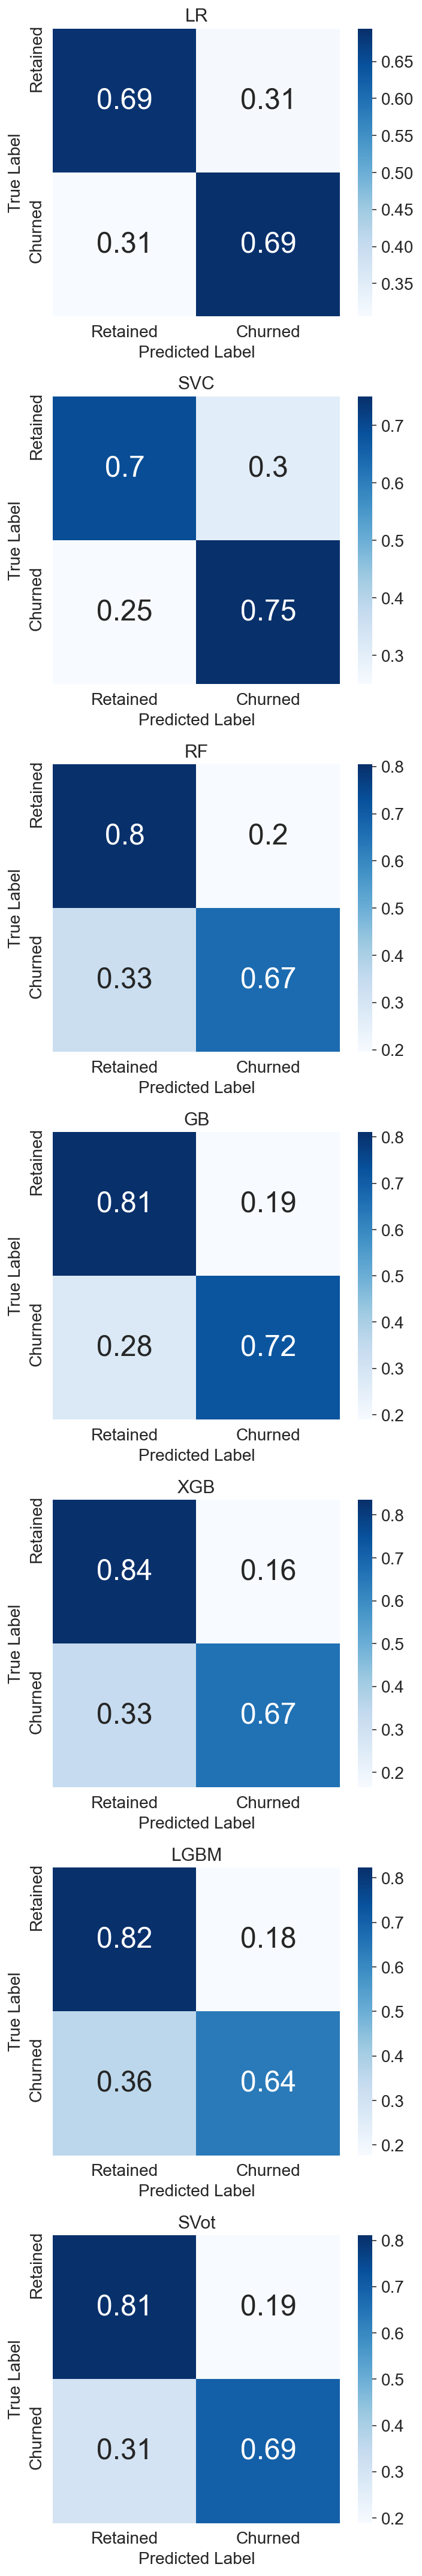

In [114]:
#fitting all models on test set

tuned_voting_soft.fit(X_train, y_train)

fig, ax = plt.subplots(7, 1, figsize=(5, 30))

for i, (name, clf) in enumerate(zip(['LR', 'SVC', 'RF', 'GB', 'XGB', 'LGBM', 'SVot'], 
                                    [best_lr_clf.best_estimator_, best_svc_clf.best_estimator_, best_rf_clf.best_estimator_, best_gbc_clf.best_estimator_, best_xgb_clf.best_estimator_, best_lgbmc_clf.best_estimator_, tuned_voting_soft])):
    test_func(clf, name, ax=ax[i])

plt.tight_layout();

In [115]:
#Comparison results in the test set 

comparison_test_df = pd.DataFrame(comparison_test_dict,
                                  index=['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color='indianred', axis=0)